# TRABAJO FINAL - LoRa

### Introducción: ¿Qué es la modulación LoRa (FSCM) y por qué se utiliza?

La modulación **LoRa** (Long Range) es un esquema de **Frequency-Shift Chirp Modulation (FSCM)**:
cada símbolo se transmite como un *chirp* (barrido lineal de frecuencia) cuya frecuencia inicial se “desplaza” de acuerdo con el valor del símbolo y luego recorre todo el ancho de banda disponible.

### ¿Por qué se emplea en LPWAN?

- **Alcance extremo con poca potencia**
  El barrido de frecuencia hace que la señal sea robusta a desvanecimientos y a interferencia narrow-band; permite enlaces de kilómetros con mili­vatios.
- **Sincronización relajada**
  La correlación de chirps tolera desalineaciones de tiempo y frecuencia, reduciendo el costo del oscilador en los nodos IoT.
- **Demodulación FFT de baja complejidad**
  Un receptor sólo necesita multiplicar por un *down-chirp* y ejecutar una FFT corta para detectar el símbolo.
- **Soporte de múltiples *Spreading Factors***
  Diferentes valores de \(SF\) producen chirps ortogonales en la misma banda, posibilitando acceso múltiple semisimultáneo (principio de LoRaWAN).

---

### Diferencias clave: LoRa (FSCM) vs. FSK y PSK

| Característica | **LoRa (FSCM)** | **FSK** | **PSK** |
|----------------|-----------------|---------|---------|
| **Portadora** | *Chirp* lineal (frecuencia barre todo \(B\)) | Tono fijo por símbolo | Fase fija por símbolo |
| **Separación de símbolos** | Desplazamiento de frecuencia inicial del chirp | Frecuencias discretas | Fases discretas |
| **Robustez a canal selectivo** | Alta (el barrido promedia \(\!\!\notch\!\!\) de canal) | Baja (si la frecuencia cae en un notch, símbolo se pierde) | Media–baja (sensibles a dispersión de fase) |
| **Tolerancia a des-sincronización** | Elevada (ancho de banda completo usado por cada símbolo) | Requiere buen ajuste de frecuencia | Requiere fase coherente precisa |
| **Complejidad de receptor** | FFT de longitud $M=2^{SF}$ | Bancos de filtros o correladores | Coherente: mezclador + PLL |
| **Ganancia de procesamiento** | $\displaystyle 10\log_{10}(M)\,\mathrm{dB}$ por efecto de *spreading* | Ninguna | Ninguna |
| **Uso típico** | LPWAN, IoT, enlaces satélite de baja tasa | Telemetría simple, radio analógica | WLAN, satélite de banda ancha |

En síntesis, **LoRa** sacrifica tasa de datos (por el *spreading factor*) a cambio de:

1. **Gran sensibilidad** (~–137 dBm a SF 12 / 125 kHz).
2. **Alta inmunidad a multipath** comparada con FSK y PSK.
3. **Receptores baratos y de bajo consumo**, ideales para dispositivos IoT que transmiten esporádicamente a largas distancias.

Estas propiedades explican la adopción masiva de LoRa/LoRaWAN en redes de sensores, seguimiento logístico y aplicaciones rurales o industriales donde la cobertura celular no es viable.


## Desarrollo de trabajo

Imports necesarios para la implementación.

In [3]:
%pip install numpy
%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


### Determinación del número de símbolos

Para definir la cantidad adecuada de símbolos a simular, se tomó como referencia la región de **SNR más alta**, donde el **BER** es menor y se requieren más muestras para obtener una estimación confiable.  

A partir del criterio de disponer al menos **100 bits erróneos** $ (N_{e,min} = 100) $ por punto, se utilizó la siguiente relación:

$$
N_s^{req} = \frac{N_{e,min}}{BER \times SF}
$$

Con $ SF = 7 $ y los valores de $ BER $ obtenidos de la curva, se determinó que para  
$ SNR = -3\,\text{dB} $ (donde $ BER = 5\times10^{-5} $) se requieren aproximadamente:

$$
N_s^{req} \approx 2.86\times10^{5}
$$


In [3]:
SF = 7
M = 2**SF
B = 125e3         # Ancho de banda
T = 1/B           # Periodo de muestra
num_symbols = 286000
num_bits = num_symbols * SF


Generamos una secuencia de bits aleatorios y, a partir de ella (bits_tx), construimos los símbolos correspondientes.

In [4]:
bits_tx = np.random.randint(0, 2, size=num_bits)

## Encoder: conversión de bits a símbolos

Agrupamos los bits en símbolos \([0,\,M-1]\).

**Objetivo**
Crear el vector `symbols_tx` a partir de `bits_tx`, guardando el bit más significativo (MSB) en el índice 0 de cada bloque de \(SF\) bits.

### Pasos

- **Índices**
  - **i**: recorre los símbolos,
    $i = 0,\dots,\text{num\_symbols}-1$
  - **j**: recorre los bits dentro de un símbolo,
    $j = 0,\dots,SF-1$

- **Peso de cada bit**
  Para poner el MSB en la posición correcta empleamos el desplazamiento:
  $$
  \text{peso}(j) \;=\; 2^{\,SF-1-j}.
  $$

- **Cálculo del símbolo**
  $$
  \texttt{symbol}_i
  \;=\;
  \sum_{j=0}^{SF-1}
  \texttt{bits\_tx}[\,i\!\cdot\!SF + j\,]\;
  2^{SF-1-j}.
  $$

- **Resultado**
  `symbols_tx` es un vector de enteros en el rango \([0,\,M-1]\) listo para alimentar el modulador.

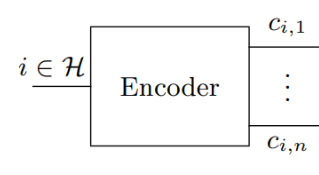


In [5]:
def encode_bits_to_symbols(bits, SF):
    n_sym = len(bits) // SF
    return np.array([
        sum(bits[i*SF + j] << (SF-1-j) for j in range(SF))
        for i in range(n_sym)
    ])

### Waveform Former  

Generación de un *up-chirp* desplazado según la **ecuación (2)** de Vangelista para un símbolo
$$
s \in \{0,\dots,2^{SF}-1\}.
$$

Ecuación (2)
$$
c[k] \;=\;
\frac{1}{\sqrt{2^{SF}}}\,
\exp\!\Bigl(
  j\,2\pi\;
  \bigl((s+k)\bmod 2^{SF}\bigr)\,k\,T\,\frac{B}{2^{SF}}
\Bigr),
\qquad k = 0,\dots,2^{SF}-1.
$$

Cada símbolo dura  
$$
T_s = 2^{SF}\,T
$$  
donde \(T = 1/B\) es el período de muestreo y \(B\) el ancho de banda.

- **Vector de índices**  
  $$
  k = 0,1,\dots,2^{SF}-1
  $$

- **Fase desplazada**  
  $$
  \phi[k] \;=\;
  2\pi\,
  \bigl((s+k)\bmod 2^{SF}\bigr)\,k\,T\,\frac{B}{2^{SF}}
  $$

- **Chirp normalizado**  
  $$
  c[k] \;=\;
  \frac{1}{\sqrt{2^{SF}}}\,
  e^{\,j\phi[k]}
  $$

Este diseño garantiza:

1. **Ortogonalidad**: los $2^{SF}$ chirps resultantes son mutuamente ortogonales.

2. **Ganancia de procesamiento**: cada símbolo ocupa todo el ancho de banda $B$, aportando $10\log_{10}\!\bigl(2^{SF}\bigr)\ \mathrm{dB}$.


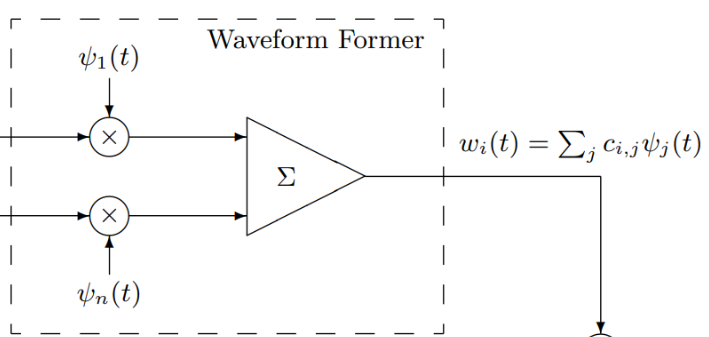

In [ ]:
def waveform_former(symbol, M, B, T):
    Ns = 2 * M  # Número de muestras es 2*M
    k = np.arange(Ns)

    # Escalamos k para que barra M bins en Ns muestras (k * M / Ns)
    k_scaled_freq = k * M / Ns

    # La fase se normaliza por Ns
    phase = ((symbol + k_scaled_freq) % M) * (k * T * B) / Ns

    chirp_waveform = np.exp(1j * 2 * np.pi * phase) / np.sqrt(Ns)
    return chirp_waveform

#### Generación de la señal transmitida

A partir del vector de símbolos (`symbols_tx`), concatenamos cada chirp generado por `waveform_former` para formar la señal completa:

In [8]:
symbols_tx = encode_bits_to_symbols(bits_tx, SF)

tx_signal = np.concatenate([waveform_former(i, M, B, T) for i in symbols_tx])

## n-Tuple Former (Matched-Filter Receiver)

La detección óptima de un símbolo en FSCM (sección III del paper de Vangelista) se realiza con un filtro adaptado y una FFT:

1. **Segmentación en bloques**
   Dividir la señal recibida `rx_signal` en bloques de $2^{SF}$ muestras:
   $$
   r^{(i)}[k]
   = r\bigl(i\,T_s + k\,T\bigr),
   \qquad
   k = 0,\dots,2^{SF}-1.
   $$

2. **Deschirp (filtro adaptado)**
   Multiplicar cada bloque por la chirp base conjugada:
   $$
   d_0[k]
   = \exp\!\Bigl(-j\,2\pi\,\frac{k^2\,T\,B}{2^{SF}}\Bigr).
   $$
   La señal dechirpeada es
   $$
   y[k]
   = r^{(i)}[k]\;\,d_0[k].
   $$

3. **FFT y decisión ML**
   Calcular la FFT de \(\{y[k]\}\):
   $$
   Y[p]
   = \sum_{k=0}^{2^{SF}-1} y[k]\;e^{-j2\pi\,\frac{p\,k}{2^{SF}}},
   \qquad
   p = 0,\dots,2^{SF}-1.
   $$
   La estimación del símbolo es
   $$
   \hat s
   = \underset{p\in\{0,\dots,2^{SF}-1\}}{\arg\max}\;\bigl|Y[p]\bigr|.
   $$

4. **Reconstrucción de la secuencia**
   Repetir para cada bloque $i$ y almacenar $\hat s_i$ en un arreglo de símbolos recibidos.

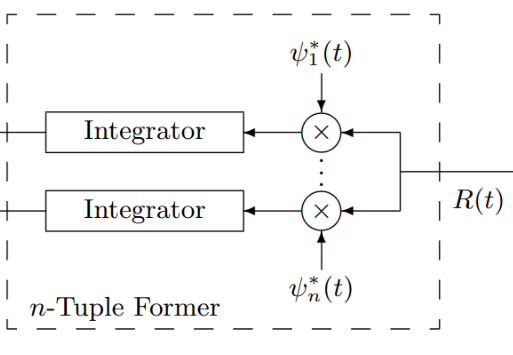

In [9]:
def nTuple_former(received_block, M, B, T):
    k = np.arange(M)
    down_chirp = np.exp(-1j * 2 * np.pi * (k * T * B) * k / M)
    reference_chirp = received_block * down_chirp
    spectrum = np.fft.fft(reference_chirp)
    return np.argmax(np.abs(spectrum))

symbols_rx = []
for idx in range(len(symbols_tx)):
    block = tx_signal[idx*M : (idx+1)*M]
    symbol_hat = nTuple_former(block, M, B, T)
    symbols_rx.append(symbol_hat)
symbols_rx = np.array(symbols_rx)

### Decoder

Reconstrucción de los bits recibidos a partir de los símbolos estimados.

Cada símbolo $\hat s\in\{0,\dots,2^{SF}-1\}$ se descompone en $SF$ bits $\{\hat w_0,\dots,\hat w_{SF-1}\}$ mediante:

$$
\hat w_h
=\left\lfloor\frac{\hat s}{2^{SF-1-h}}\right\rfloor \bmod 2,
\qquad h=0,\dots,SF-1.
$$

- **MSB primero**: \(h=0\) extrae el bit más significativo, \(h=SF-1\) el menos significativo.
- **Vector final**: aplicamos esto a cada símbolo y concatenamos los bits para obtener el flujo de salida.

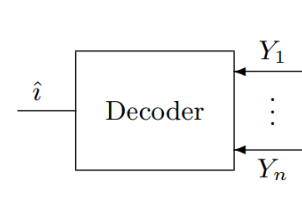

In [10]:
def decode_symbols_to_bits(symbols, SF):
    n_sym = len(symbols)
    return np.array([
        [(symbols[i] >> (SF-1-j)) & 1 for j in range(SF)]
        for i in range(n_sym)
    ]).flatten()

#### Cálculo de la tasa de error de símbolo (SER)

La **SER** (Symbol Error Rate) mide la fracción de símbolos que fueron detectados incorrectamente

In [11]:
num_symbol_errors = np.sum(symbols_tx != symbols_rx)
SER_test = num_symbol_errors / num_symbols

#### Cálculo de la tasa de error de bit (BER)

La **BER** (Bit Error Rate) mide la fracción de bits que fueron detectados incorrectamente

In [12]:
bits_rx = decode_symbols_to_bits(symbols_rx, SF)

num_bits_errors = np.sum(bits_tx != bits_rx)
BER_test = num_bits_errors / num_bits

### Test de BER y SER con canal ideal

Se realiza una prueba de los bits transmitidos como los decodificados y devolvemos el valor del BER como el SER.

In [13]:
print("SF:", SF, "→ M =", M)
print("Bits transmitidos (primeros 20): ", bits_tx[:20])
print("Bits decodificados (primeros 20):", bits_rx[:20])
print("BER ideal: ", BER_test)
print("Símbolos transmitidos (primeros 10):", symbols_tx[:10])
print("Símbolos recibidos    (primeros 10):", symbols_rx[:10])
print("SER ideal: ", SER_test)

SF: 7 → M = 128
Bits transmitidos (primeros 20):  [1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0]
Bits decodificados (primeros 20): [1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0]
BER ideal:  0.0
Símbolos transmitidos (primeros 10): [65 99 77 21 93 54 62 83 61 35]
Símbolos recibidos    (primeros 10): [65 99 77 21 93 54 62 83 61 35]
SER ideal:  0.0


## Señal con ruido AWGN

Para modelar el canal AWGN (Additive White Gaussian Noise) añadimos a cada muestra de la señal transmitida un ruido gaussiano complejo de media cero y varianza $\sigma^2$ determinada por la relación $E_s/N_0$.

Partimos de:
$$
\begin{aligned}
\texttt{snr\_dB\_range} &= -11, -10, \dots, 0,\\
\texttt{EsN0\_dB\_range} &= \texttt{snr\_dB\_range} \;+\; 10\log_{10}(M),\\
E_s &= 1.
\end{aligned}
$$

- **$\mathrm{Es}/N_0$ $(\mathrm{dB})$**  
  $\mathrm{EsN0\_dB\_range} = \mathrm{snr\_dB\_range} + 10\log_{10}(M)$.

- **Varianza del ruido**  
  $$
    \sigma^2 \;=\; \frac{E_s}{10^{\,\mathrm{EsN0\_dB}/10}}.
  $$

- **Ruido AWGN**  
  $$
    n[k]
    = \sqrt{\frac{\sigma^2}{2}}\;\bigl(\mathcal{N}(0,1) + j\,\mathcal{N}(0,1)\bigr).
  $$

- **Señal recibida**  
  $$
    r[k] = s[k] + n[k],
  $$
  donde \(s[k]\) es la muestra del chirp transmitido.

Con estos parámetros y fórmulas podemos generar el ruido apropiado y obtener la señal r[k] para cada valor de SNR en dB.  


In [14]:
snr_dB_range = np.arange(-11, 1, 1)                        # Es/N0 (dB)
EsN0_dB_range = snr_dB_range + 10*np.log10(M)              # Para simular se suma, ya que SNR dB = Es/N0 - 10log10(M)
Es = 1                                                     # Energía por símbolo (normalizada)
BER_awgn = np.zeros_like(snr_dB_range, dtype=float)
SER_awgn = np.zeros_like(snr_dB_range, dtype=float)

h_freqsel    = np.array([np.sqrt(0.8), np.sqrt(0.2)])      # √0.8 δ[n] + √0.2 δ[n-1]
BER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)
SER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)

### Cálculo de ruido AWGN y tasas de error / Señal con desplazamiento en frecuencia

Para cada valor de SNR ($\mathrm{Es}/N_0$ en dB) se realiza lo siguiente:

1. **Parámetros de ruido**  
   - $\mathrm{Es}/N_0$ en dB:
     $$
       \mathrm{EsN0}_{\mathrm{dB}}
       = \mathrm{snr\_dB}
       + 10\log_{10}(M).
     $$
   - Relación lineal:
     $\displaystyle \mathit{SNR} = 10^{\mathrm{EsN0}_{\mathrm{dB}}/10}$.

   - Densidad espectral de ruido:
     $\displaystyle N_0 = \frac{E_s}{\mathit{SNR}},\quad E_s=1$.

   - Desviación típica por dimensión:
     $\displaystyle \sigma = \sqrt{\frac{N_0}{2}}$.

2. **Señal con AWGN**
   - Generar ruido complejo:
     $$
       n[k]
       = \sigma\bigl(\mathcal{N}(0,1) + j\,\mathcal{N}(0,1)\bigr).
     $$
   - Señal recibida:
     $$
       r_{\mathrm{AWGN}}[k]
       = s[k] + n[k],
     $$
     donde \(s[k]\) es la muestra de `tx_signal`.

3. **Demodulación y reconstrucción de bits**
   - Dividir $r_{\mathrm{AWGN}}$ en bloques de $2^{SF}$ muestras (un chirp).

   - Aplicar *n-Tuple Former* a cada bloque para obtener $\hat s_i$.

   - Reconstruir bits $\hat b_n$ de $\{\hat s_i\}$.

4. **Cálculo de BER y SER**
   - $\displaystyle \mathrm{BER}_{\mathrm{AWGN}} = \frac{\#\{b_{\mathrm{tx}}\neq b_{\mathrm{rx}}\}}{\text{num\_bits}}$.

   - $\displaystyle \mathrm{SER}_{\mathrm{AWGN}} = \frac{\#\{s_{\mathrm{tx}}\neq s_{\mathrm{rx}}\}}{\text{num\_symbols}}$.

5. **Señal selectiva en frecuencia**
   - Convolucionar `tx_signal` con la respuesta
     $h[n]=\sqrt{0.8}\,\delta[n] + \sqrt{0.2}\,\delta[n-1]$.

   - Repetir los pasos 2–4 usando la misma $\sigma$
     para obtener $\mathrm{BER}_{\text{FreqSel}}$ y $\mathrm{SER}_{\text{FreqSel}}$.

Estos resultados se almacenan en vectores para graficar posteriormente las curvas de BER y SER frente a SNR (dB).


In [15]:
for idx, snr_dB in enumerate(EsN0_dB_range):
    SNR   = 10**(snr_dB / 10)               # relación lineal Potencia_señal / Potencia_ruido
    N0    = Es / SNR                        # densidad espectral de ruido
    sigma = np.sqrt(N0/2)                   # desviación típica por dimensión / estandar

    # Generación de ruido AWGN complejo
    noise = sigma * (np.random.randn(len(tx_signal)) + 1j*np.random.randn(len(tx_signal)))

    # Señal recibida con AWGN
    rx_signal = tx_signal + noise

    # Demodulación símbolo a símbolo
    symbols_rx = []
    for sym_idx in range(len(symbols_tx)):
        block = rx_signal[sym_idx*M : (sym_idx+1)*M]
        symbols_rx.append(nTuple_former(block, M, B, T))
    symbols_rx = np.array(symbols_rx)

    # Decodificación a bits
    bits_rx_awgn = decode_symbols_to_bits(symbols_rx, SF)

    # Cálculo de tasas de error
    SER_awgn[idx] = np.sum(symbols_tx != symbols_rx) / num_symbols
    BER_awgn[idx] = np.sum(bits_tx != bits_rx_awgn) / num_bits

    # Se realiza ahora para la señal selectiva en frecuencia
    tx_faded = np.convolve(tx_signal, h_freqsel, mode='full')[:len(tx_signal)]

    # AWGN con el mismo sigma ya calculado
    noise_sel     = sigma * (np.random.randn(len(tx_faded)) + 1j*np.random.randn(len(tx_faded)))
    rx_signal_sel = tx_faded + noise_sel

    # Demodulación símbolo a símbolo (idéntica a la de AWGN)
    symbols_rx_sel = []
    for sym_idx in range(len(symbols_tx)):
        block_sel = rx_signal_sel[sym_idx*M : (sym_idx+1)*M]
        symbols_rx_sel.append(nTuple_former(block_sel, M, B, T))
    symbols_rx_sel = np.array(symbols_rx_sel)

    # Decodificación a bits
    bits_rx_sel = decode_symbols_to_bits(symbols_rx_sel, SF)

    # Tasas de error
    SER_freqsel[idx] = np.sum(symbols_tx != symbols_rx_sel) / num_symbols
    BER_freqsel[idx] = np.sum(bits_tx != bits_rx_sel) / num_bits

    print(f"SNRdB = {snr_dB_range[idx]:5.1f}: "
          f"BER_AWGN = {BER_awgn[idx]:.3e}, SER_AWGN = {SER_awgn[idx]:.3e} | "
          f"BER_FreqSel = {BER_freqsel[idx]:.3e}, SER_FreqSel = {SER_freqsel[idx]:.3e}")

SNRdB = -11.0: BER_AWGN = 5.064e-02, SER_AWGN = 1.002e-01 | BER_FreqSel = 1.027e-01, SER_FreqSel = 2.251e-01
SNRdB = -10.0: BER_AWGN = 1.883e-02, SER_AWGN = 3.774e-02 | BER_FreqSel = 5.365e-02, SER_FreqSel = 1.258e-01
SNRdB =  -9.0: BER_AWGN = 4.963e-03, SER_AWGN = 9.822e-03 | BER_FreqSel = 2.430e-02, SER_FreqSel = 6.266e-02
SNRdB =  -8.0: BER_AWGN = 7.937e-04, SER_AWGN = 1.612e-03 | BER_FreqSel = 9.689e-03, SER_FreqSel = 2.899e-02
SNRdB =  -7.0: BER_AWGN = 7.443e-05, SER_AWGN = 1.503e-04 | BER_FreqSel = 3.905e-03, SER_FreqSel = 1.319e-02
SNRdB =  -6.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 1.605e-03, SER_FreqSel = 5.727e-03
SNRdB =  -5.0: BER_AWGN = 2.498e-06, SER_AWGN = 3.497e-06 | BER_FreqSel = 6.364e-04, SER_FreqSel = 2.280e-03
SNRdB =  -4.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 1.983e-04, SER_FreqSel = 7.238e-04
SNRdB =  -3.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 6.144e-05, SER_FreqSel = 2.028e-04
SNRdB =  -2.0: BER_


## La escala en decibeles y la relación señal/ruido

La escala en decibeles (dB) es logarítmica y mide la razón potencia-señal a potencia-ruido:

$$
\mathrm{SNR}_{\mathrm{dB}}
=10\,\log_{10}\!\Bigl(\frac{P_{\mathrm{señal}}}{P_{\mathrm{ruido}}}\Bigr).
$$

**Menos dB ⇒ menor relación señal/ruido.**
Al bajar el SNR en dB (por ejemplo, de 0 dB a –10 dB), el ruido domina la señal:

- **En 0 dB**:
  $$
  P_{\mathrm{señal}} = P_{\mathrm{ruido}}.
  $$

- **En –10 dB**:
  $$
  P_{\mathrm{señal}} \approx 0.1\,P_{\mathrm{ruido}},
  $$
  (la señal es 10× más débil que el ruido).

Por tanto, a menor $\mathrm{SNR}_{\mathrm{dB}}$ la probabilidad de error **aumenta**;
a mayor $\mathrm{SNR}_{\mathrm{dB}}$ la señal “destaca” y los errores caen exponencialmente.



#### La implementación de lo realizado anteriormente

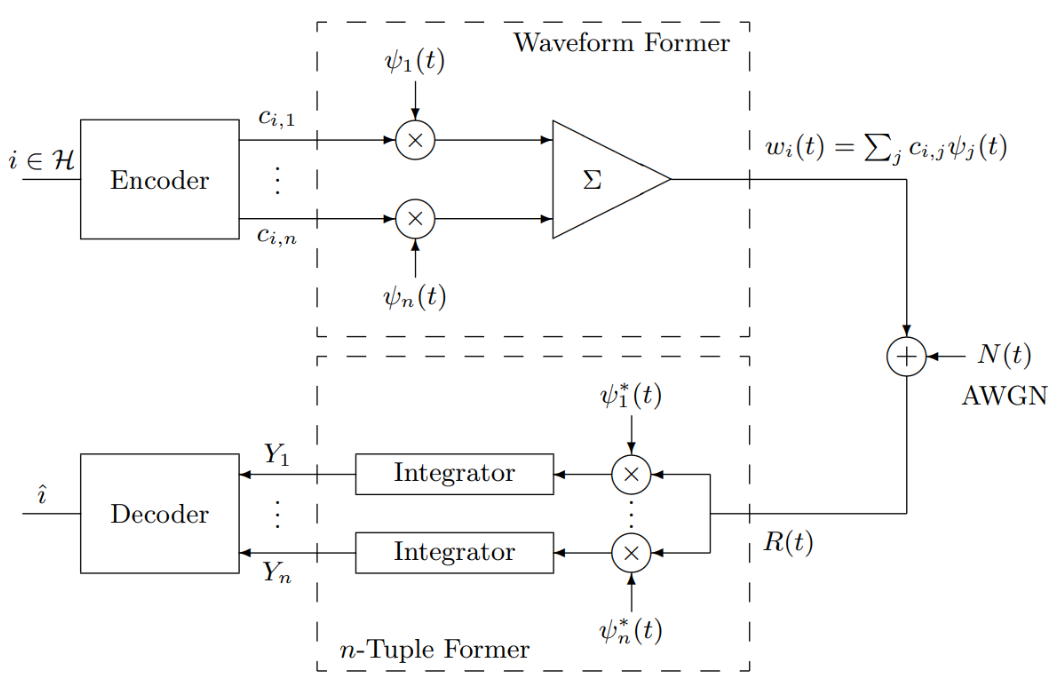

### Grafica de curvas de BER y SER AWGN

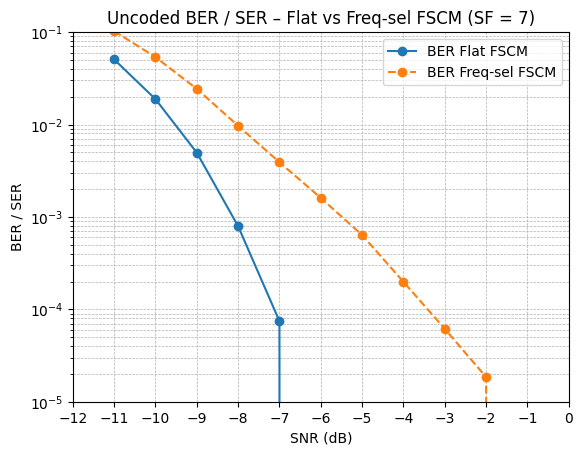

In [16]:
plt.figure()
plt.semilogy(snr_dB_range, BER_awgn,    'o-',  label='BER Flat FSCM')
#plt.semilogy(snr_dB_range, SER_awgn,    's-',  label='SER Flat FSCM')
plt.semilogy(snr_dB_range, BER_freqsel, 'o--', label='BER Freq-sel FSCM')
#plt.semilogy(snr_dB_range, SER_freqsel, 's--', label='SER Freq-sel FSCM')

plt.xlim(-12, 0)
plt.ylim(1e-5, 1e-1)
plt.xticks(np.arange(-12, 1, 1))
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('BER / SER')
plt.title('Uncoded BER / SER – Flat vs Freq-sel FSCM (SF = 7)')
plt.legend()
plt.show()

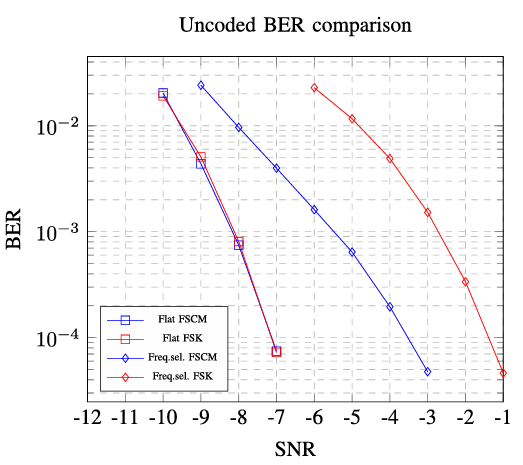

In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#===========================================================================================
#                        VISUALIZACIÓN DE LA TRAMA EN EL TIEMPO
#===========================================================================================
def plot_lora_frame_zoom(signal, M, SF, B, preamble_len=8, netid_len=2):
    """
    Grafica la trama LoRa completa con vistas ampliadas de cada sección
    """
    # Configuración de tiempos
    T = 1/B
    t = np.arange(len(signal)) * T * 1e3  # Tiempo en milisegundos
    
    # Límites de cada sección
    preamble_end = preamble_len * M
    netid_end = preamble_end + netid_len * M
    sfd_end = netid_end + int(2.25 * M)
    payload_start = sfd_end
    
    # Crear figura con subplots - ahora más grande para incluir zoom
    fig = plt.figure(figsize=(16, 14))
    
    # Definir la cuadrícula de subplots
    gs = gridspec.GridSpec(6, 2, height_ratios=[1, 1, 1, 1, 1, 1])
    
    # 1. Parte Real - Vista completa (arriba)
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(t, np.real(signal), linewidth=1)
    ax1.axvline(t[preamble_end], color='r', linestyle='--', label='Fin Preámbulo')
    ax1.axvline(t[netid_end], color='g', linestyle='--', label='Fin NetID')
    ax1.axvline(t[sfd_end], color='b', linestyle='--', label='Fin SFD')
    ax1.set_ylabel('Amplitud')
    ax1.set_title(f'Trama LoRa Completa (SF={SF}) - Parte Real')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Parte Imaginaria - Vista completa
    ax2 = plt.subplot(gs[1, :])
    ax2.plot(t, np.imag(signal), linewidth=1, color='orange')
    ax2.axvline(t[preamble_end], color='r', linestyle='--')
    ax2.axvline(t[netid_end], color='g', linestyle='--')
    ax2.axvline(t[sfd_end], color='b', linestyle='--')
    ax2.set_ylabel('Amplitud')
    ax2.set_title('Parte Imaginaria - Vista Completa')
    ax2.grid(True, alpha=0.3)
    
    # 3. VISTAS AMPLIADAS - PREÁMBULO
    ax3 = plt.subplot(gs[2, 0])
    preamble_samples = M * 2  # Mostrar 2 símbolos del preámbulo
    start_idx = 0
    end_idx = min(preamble_samples, len(signal))
    ax3.plot(t[start_idx:end_idx], np.real(signal[start_idx:end_idx]), linewidth=1.5)
    ax3.set_title('Zoom: Preámbulo (Parte Real)')
    ax3.set_ylabel('Amplitud')
    ax3.grid(True, alpha=0.3)
    
    # 4. VISTAS AMPLIADAS - NETID
    ax4 = plt.subplot(gs[2, 1])
    netid_samples = M * 2  # Mostrar 2 símbolos del NetID
    start_idx = preamble_end
    end_idx = min(preamble_end + netid_samples, len(signal))
    ax4.plot(t[start_idx:end_idx], np.real(signal[start_idx:end_idx]), linewidth=1.5, color='green')
    ax4.set_title('Zoom: NetID (Parte Real)')
    ax4.set_ylabel('Amplitud')
    ax4.grid(True, alpha=0.3)
    
    # 5. VISTAS AMPLIADAS - SFD
    ax5 = plt.subplot(gs[3, 0])
    sfd_samples = int(2.25 * M)  # Mostrar todo el SFD
    start_idx = netid_end
    end_idx = min(netid_end + sfd_samples, len(signal))
    ax5.plot(t[start_idx:end_idx], np.real(signal[start_idx:end_idx]), linewidth=1.5, color='blue')
    ax5.set_title('Zoom: SFD (Parte Real)')
    ax5.set_ylabel('Amplitud')
    ax5.grid(True, alpha=0.3)
    
    # 6. VISTAS AMPLIADAS - PAYLOAD (inicio)
    ax6 = plt.subplot(gs[3, 1])
    payload_samples = M * 2  # Mostrar primeros 2 símbolos del payload
    start_idx = payload_start
    end_idx = min(payload_start + payload_samples, len(signal))
    if end_idx > start_idx:
        ax6.plot(t[start_idx:end_idx], np.real(signal[start_idx:end_idx]), linewidth=1.5, color='purple')
    ax6.set_title('Zoom: Inicio del Payload (Parte Real)')
    ax6.set_ylabel('Amplitud')
    ax6.grid(True, alpha=0.3)
    
    # 7. Magnitud - Vista completa
    ax7 = plt.subplot(gs[4, :])
    ax7.plot(t, np.abs(signal), linewidth=1, color='purple')
    ax7.axvline(t[preamble_end], color='r', linestyle='--')
    ax7.axvline(t[netid_end], color='g', linestyle='--')
    ax7.axvline(t[sfd_end], color='b', linestyle='--')
    ax7.set_ylabel('Magnitud')
    ax7.set_title('Magnitud de la Señal - Vista Completa')
    ax7.grid(True, alpha=0.3)
    
    # 8. Fase instantánea - Vista completa
    ax8 = plt.subplot(gs[5, :])
    phase = np.unwrap(np.angle(signal))
    ax8.plot(t, phase, linewidth=1, color='green')
    ax8.axvline(t[preamble_end], color='r', linestyle='--')
    ax8.axvline(t[netid_end], color='g', linestyle='--')
    ax8.axvline(t[sfd_end], color='b', linestyle='--')
    ax8.set_ylabel('Fase (rad)')
    ax8.set_xlabel('Tiempo (ms)')
    ax8.set_title('Fase Instantánea - Vista Completa')
    ax8.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Función adicional para mostrar solo las vistas ampliadas
def plot_lora_zoom_sections(signal, M, SF, B, preamble_len=8, netid_len=2):
    """
    Grafica solo las vistas ampliadas de cada sección de la trama LoRa
    """
    T = 1/B
    t = np.arange(len(signal)) * T * 1e3
    
    # Límites de cada sección
    preamble_end = preamble_len * M
    netid_end = preamble_end + netid_len * M
    sfd_end = netid_end + int(2.25 * M)
    payload_start = sfd_end
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # 1. Zoom Preámbulo
    samples = M * 3  # 3 símbolos
    start_idx = 0
    end_idx = min(samples, preamble_end)
    axes[0].plot(t[start_idx:end_idx], np.real(signal[start_idx:end_idx]), linewidth=2)
    axes[0].plot(t[start_idx:end_idx], np.imag(signal[start_idx:end_idx]), linewidth=2, color='orange')
    axes[0].set_title(f'Zoom: Preámbulo (Primeros 3 símbolos)\nSF={SF}')
    axes[0].set_ylabel('Amplitud')
    axes[0].legend(['Real', 'Imag'])
    axes[0].grid(True, alpha=0.3)
    
    # 2. Zoom NetID
    samples = M * 2  # 2 símbolos
    start_idx = preamble_end
    end_idx = min(preamble_end + samples, netid_end)
    axes[1].plot(t[start_idx:end_idx], np.real(signal[start_idx:end_idx]), linewidth=2, color='green')
    axes[1].plot(t[start_idx:end_idx], np.imag(signal[start_idx:end_idx]), linewidth=2, color='red')
    axes[1].set_title('Zoom: NetID')
    axes[1].set_ylabel('Amplitud')
    axes[1].legend(['Real', 'Imag'])
    axes[1].grid(True, alpha=0.3)
    
    # 3. Zoom SFD
    start_idx = netid_end
    end_idx = sfd_end
    axes[2].plot(t[start_idx:end_idx], np.real(signal[start_idx:end_idx]), linewidth=2, color='blue')
    axes[2].plot(t[start_idx:end_idx], np.imag(signal[start_idx:end_idx]), linewidth=2, color='cyan')
    axes[2].set_title('Zoom: SFD')
    axes[2].set_xlabel('Tiempo (ms)')
    axes[2].set_ylabel('Amplitud')
    axes[2].legend(['Real', 'Imag'])
    axes[2].grid(True, alpha=0.3)
    
    # 4. Zoom Payload (inicio)
    samples = M * 2  # 2 símbolos
    start_idx = payload_start
    end_idx = min(payload_start + samples, len(signal))
    if end_idx > start_idx:
        axes[3].plot(t[start_idx:end_idx], np.real(signal[start_idx:end_idx]), linewidth=2, color='purple')
        axes[3].plot(t[start_idx:end_idx], np.imag(signal[start_idx:end_idx]), linewidth=2, color='magenta')
    axes[3].set_title('Zoom: Inicio del Payload')
    axes[3].set_xlabel('Tiempo (ms)')
    axes[3].set_ylabel('Amplitud')
    axes[3].legend(['Real', 'Imag'])
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_spectrogram(signal, B, SF, M, section='preamble'):
    """
    Espectrograma con zoom en una sección específica
    """
    from scipy import signal as scipy_signal
    
    fs = 2 * B
    
    # Definir región de interés
    if section == 'preamble':
        start_sample = 0
        end_sample = 8 * M
        title = "Preambulo (8 Up-Chirps)"
    elif section == 'sfd':
        start_sample = 10 * M
        end_sample = start_sample + int(2.25 * M)
        title = "SFD (Down-Chirps)"
    elif section == 'data':
        start_sample = int(12.25 * M)
        end_sample = start_sample + 10 * M
        title = "Primeros 10 Simbolos de Datos"
    else:
        start_sample = 0
        end_sample = len(signal)
        title = "Senal Completa"
    
    signal_zoom = signal[start_sample:end_sample]
    
    nperseg = M // 2
    noverlap = int(nperseg * 0.95)
    
    f, t, Sxx = scipy_signal.spectrogram(
        signal_zoom, 
        fs=fs, 
        nperseg=nperseg,
        noverlap=noverlap,
        window='hann',
        scaling='spectrum',
        return_onesided=False,
        mode='magnitude'
    )
    
    # Reordenar frecuencias
    f = np.fft.fftshift(f)
    Sxx = np.fft.fftshift(Sxx, axes=0)
    
    Sxx_dB = 10 * np.log10(np.abs(Sxx) + 1e-12)
    
    plt.figure(figsize=(14, 7))
    plt.pcolormesh(t * 1e3, f/1e3, Sxx_dB, 
                   shading='gouraud', 
                   cmap='jet',
                   vmin=np.max(Sxx_dB) - 50,
                   vmax=np.max(Sxx_dB))
    
    plt.colorbar(label='Potencia (dB)')
    plt.ylabel('Frecuencia (kHz)')
    plt.xlabel('Tiempo (ms)')
    plt.title(f'Espectrograma LoRa - {title} (SF={SF})')
    plt.ylim([-B/1e3, B/1e3])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

---

# **From Demodulation to Decoding: Toward Complete LoRaPHY Understanding and Implementation**

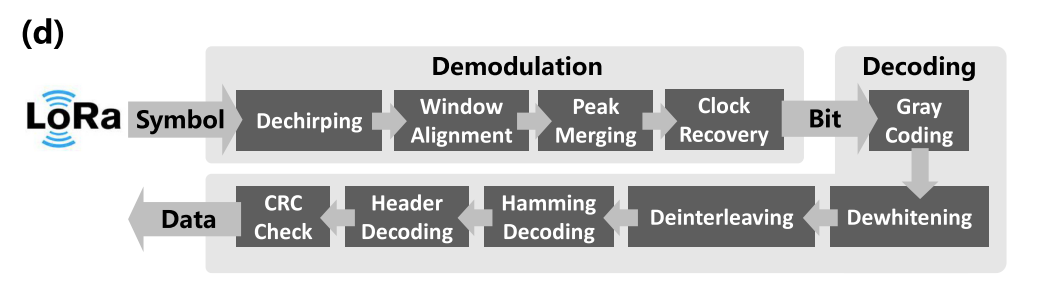

Aunque LoRa ha recibido mucha atención en la academia y en la industria, los detalles de la capa física de LoRa es decir, cómo LoRa demodula y decodifica la señal recibida aún no son completamente conocidos, ya que la PHY de LoRa es un protocolo cerrado propiedad de **Semtech Corporation**.
En la parte de **demodulación**, se revela que la causa fundamental de la pérdida de SNR es la desalineación de fase, provocada por una desalineación de ventana 
(window misalignment) y un desfase interno de símbolo.

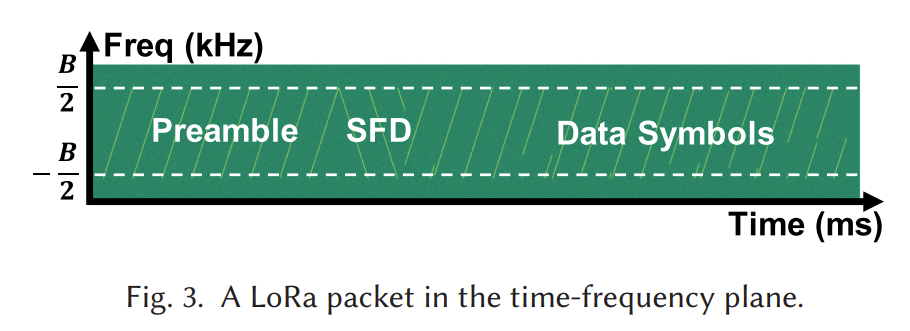

La Figura muestra la comprensión básica de un paquete LoRa estándar. 
En general, tiene tres partes: preambulo, delimitador de inicio de trama (SFD) y símbolos de datos.

- El preambulo es una serie de up-chirps base seguidos por dos símbolos up-chirp que indican el ID de red. El up-chirp base es simplemente el chirp sin desplazamiento, es decir: símbolo = 0 → no hay corrimiento en frecuencia.

- El SFD consiste en 2,25 down-chirps que indican el inicio de los símbolos de datos.

- Los símbolos de datos incluyen el encabezado PHY, la carga útil (payload) y el CRC de la carga útil (el encabezado y el CRC son opcionales).

---

# Preámbulo, NetID y SFD

El paquete transmitido concatena:

1. *Preámbulo:* $N_p$ up-chirps base (típicamente 8).  
2. *NetID:* 2 up-chirps con los bins del identificador de red.  
3. *SFD:* $2 + \tfrac{1}{4}$ down-chirps (marca el inicio de los datos).  
4. *Datos:* secuencia de up-chirps cíclicamente desplazados según los símbolos.


Un chirp LoRa (complejo en banda base) puede verse como:
$$
s_k[n] \;=\; \exp\!\left(j\,2\pi\,\frac{(n)(n + 2k)}{2M}\right), \quad n=0,\dots,M-1,
$$
donde $M=2^{SF}$ es el número de bins/samples por símbolo y \(k\) el bin (símbolo) seleccionado.

In [ ]:
#===========================================================================================
#                           GENERACIÓN DE PREÁMBULO, NETID Y SFD
#===========================================================================================
def preamble_netid_sfd(M, B, T, preamble_len=8, netid_symbols=(24, 32)):
    up_chirp_0 = waveform_former(0, M, B, T) # (Tendrá 2M muestras)

    Ns = 2 * M # Definimos Ns
    k = np.arange(Ns) # k va hasta 2M
    # Usamos la misma lógica que make_down_ref
    down_chirp = np.exp(-1j * 2 * np.pi * (k * T * B) * k / Ns) 

    preamble = np.tile(up_chirp_0, preamble_len)

    netid = np.concatenate([waveform_former(s, M, B, T) for s in netid_symbols])

    chirp_len = len(up_chirp_0) # chirp_len será 2*M
    sfd = np.concatenate([
        down_chirp,
        down_chirp,
        down_chirp[:chirp_len//4] # (chirp_len//4 ahora es (2M)//4 = M//2)
    ])

    return preamble, netid, sfd

#===========================================================================================
#                           MODULACIÓN CON PREÁMBULO, NETID Y SFD
#===========================================================================================
def lora_modulate(symbols_tx, M, B, T):
    preamble, netid, sfd = preamble_netid_sfd(M, B, T)
    data_waveform = np.concatenate([waveform_former(i, M, B, T) for i in symbols_tx])
    return np.concatenate([preamble, netid, sfd, data_waveform])

# CFO (Carrier Frequency Offset)

El **CFO** es la diferencia entre la frecuencia portadora del transmisor y la frecuencia esperada por el receptor.

El CFO surge principalmente por:

1. **Imperfecciones en osciladores**: Los cristales de cuarzo no son perfectos
2. **Efecto Doppler**: Movimiento relativo entre transmisor y receptor
3. **Deriva térmica**: Cambios de temperatura afectan la frecuencia del oscilador

### **Efecto matemático del CFO**

Cuando hay un CFO de `Δf` Hz, la señal recibida se multiplica por una exponencial compleja rotatoria:

```
r(t) = s(t) · e^(j2π·Δf·t)
```

En tiempo discreto (con muestreo a `fs`):

```
r[n] = s[n] · e^(j2π·Δf·n/fs)
```

En LoRa, el CFO es particularmente importante porque causa un desplazamiento constante en los bins de FFT después del dechirping. El documento describe que el LoRaPHY implementa compensación dinámica de CFO usando la deriva SFO (Sampling Frequency Offset) calculada como `Δbin = (CFO/f_RF) · 2^SF`.

### Ejemplo numérico

- `cfo_hz = 1000` Hz (1 kHz de offset)
- `fs_eff = 250000` Hz (250 kHz de ancho de banda × 2)
- Después de 1 ms (250 muestras): fase acumulada = `2π·1000·0.001 = 2π` radianes = 1 rotación completa

In [13]:
#===========================================================================================
#                          FUNCION DE SIMULACIÓN DE CFO
#===========================================================================================
def inject_cfo(x: np.ndarray, cfo_hz: float, fs_eff: float, start_idx: int = 0) -> np.ndarray:
    if cfo_hz == 0.0:
        return x
    y = np.array(x, copy=True)
    n = np.arange(len(y) - start_idx, dtype=float)
    rot = np.exp(1j * 2 * np.pi * cfo_hz * n / float(fs_eff))
    y[start_idx:] *= rot
    return y

# DECHIRP 

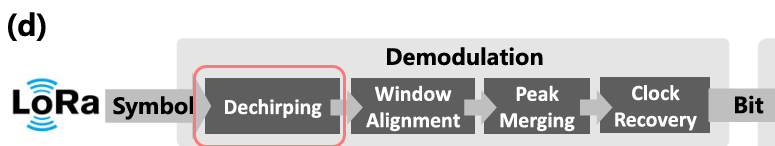

In [ ]:
#===========================================================================================
#                               FUNCIÓN DECHIRP (con ZP + peak merging)
#===========================================================================================
#           Dechirp + FFT con zero-padding + peak-merging.
#           Retorna:
#               ft_abs: magnitud plegada
#               pk_zp: índice entero del pico en resolución ZP (0..M*ZP-1)
#               pk_base_round: índice base M por redondeo (0..M-1)
#===========================================================================================
def dechirp(signal, start_idx, Ns, M, zp_factor, ref):
    seg = signal[start_idx : start_idx + Ns]
    if len(seg) < Ns:
        return None, None, None

    dechirped = seg * np.conj(ref)
    Nfft = int(Ns * zp_factor)
    spec = np.fft.fft(dechirped, n=Nfft)

    bin_num = int(M * zp_factor)
    pos = np.abs(spec[:bin_num])
    neg = np.abs(spec[-bin_num:])
    ft_abs = pos + neg             

    pk_zp = int(np.argmax(ft_abs))
    pk_base_round = int(np.round(pk_zp / zp_factor)) % M
    return ft_abs, pk_zp, pk_base_round

#===========================================================================================
#                               REFERENCIAS DE CHIRP
#===========================================================================================
def make_down_ref(M, B, T):
    Ns = 2 * M
    k = np.arange(Ns)
    return np.exp(-1j * 2 * np.pi * (k * T * B) * k / M) / np.sqrt(M)


# Detección de Trama LoRa

Esta función implementa el **detector de preámbulo** de LoRa, que es el primer paso crítico para sincronizar con una trama entrante.

El **preámbulo** consiste en 6+ upchirps **idénticos** (base chirps con frecuencia inicial = 0).

### 1. **Buscamos upchirps consecutivos coherentes**

```python
while ii < sig_len - Ns * preamble_len:
    # Dechirp del símbolo actual
    mag, pk_zp, pk_base = dechirp(signal, ii, Ns, M, zp, up_ref)
```

- Aplica **dechirping** con un downchirp de referencia
- Un upchirp base × downchirp = tono de frecuencia ~0
- Después del FFT, obtienes un **pico en el mismo bin** para todos los upchirps del preámbulo

### 2. **Verificamos coherencia entre picos**

```python
diff = (pk_bases[-1] - pk_base) % bin_num
if diff > bin_num / 2:
    diff = bin_num - diff
if diff <= max(1, int(zp)):
    pk_bases = np.append(pk_bases, pk_base)
else:
    pk_bases = np.array([pk_base], dtype=int)
```

- Los upchirps del preámbulo deben tener el **mismo bin de pico** (±tolerancia por ruido/CFO)
- `diff <= max(1, int(zp))`: tolera una diferencia de ~1 bin base (el zero-padding amplifica la resolución)
- Si encuentra un bin muy diferente → **no es parte del preámbulo** → reinicia la búsqueda

### 3. **Alineación temporal**

```python
if pk_bases.size == preamble_len - 1:
    x = ii - round((pk_bases[-1])/zp)
    return max(0, x)
```

Cuando detecta `preamble_len - 1` upchirps consecutivos coherentes:

- **Corrige el offset temporal**: `pk_bases[-1]/zp` convierte el bin con zero-padding al bin base
- Este bin representa el **desplazamiento de fase** del símbolo
- Retrocede `ii` por esa cantidad para alinear la ventana de demodulación

In [15]:
#===========================================================================================
#                               DETECCIÓN DE TRAMA
#===========================================================================================
def detect(signal, start_idx, Ns, preamble_len, M, zp, up_ref, mag_threshold=None):
    ii = int(start_idx)
    pk_bases = np.array([], dtype=int)
    sig_len = len(signal)
    bin_num = int(M * zp)

    while ii < sig_len - Ns * preamble_len:
        # Se detectaron suficientes upchirps
        if pk_bases.size == preamble_len - 1:
            x = ii - round((pk_bases[-1])/zp)
            return max(0, x)

        # Dechirp del símbolo actual
        mag, pk_zp, pk_base = dechirp(signal, ii, Ns, M, zp, up_ref)
        if mag is None:
            return -1
        # Umbral opcional
        if mag_threshold is not None and mag[pk_zp] < mag_threshold:
            pk_bases = np.array([], dtype=int)
            ii += Ns
            continue

        # Verificar coherencia entre bins consecutivos
        if pk_bases.size > 0:
            diff = (pk_bases[-1] - pk_base) % bin_num
            if diff > bin_num / 2:
                diff = bin_num - diff
            if diff <= max(1, int(zp)):
                pk_bases = np.append(pk_bases, pk_base)
            else:
                pk_bases = np.array([pk_base], dtype=int)
        else:
            pk_bases = np.array([pk_base], dtype=int)

        ii += Ns

    return -1

# WINDOW ALINGMENT

Necesitamos alinear con precisión la ventana de demodulación (a nivel de puntos de muestreo) con cada símbolo, con el fin de conservar la energía de todo el símbolo durante el proceso de demodulación. Usar únicamente la correlación con el preámbulo no permite lograr una alineación precisa debido al Desplazamiento de Frecuencia de Portadora (CFO).
Aprovechamos la parte del SFD en el paquete LoRa para la alineación de la ventana, eliminando al mismo tiempo el impacto del CFO. 
La operación clave consiste en combinar los chirps descendentes del SFD con los chirps ascendentes del preámbulo. Aplicamos dechirping a ambos. Si la ventana de demodulación está perfectamente alineada con la señal, entonces el pico del chirp ascendente y el pico 
del chirp descendente aparecen en la misma frecuencia, independientemente del CFO. De lo contrario, existe una diferencia significativa en la frecuencia de los dos picos, dependiendo del desfase temporal entre el chirp y la ventana de demodulación. Por lo tanto, podemos lograr una alineación precisa basándonos en la frecuencia de los picos correspondientes al preámbulo y a los SFD. 

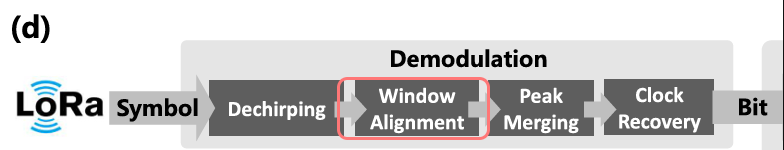

## Objetivo Principal
Encontrar la **alineación temporal fina** de la trama LoRa para maximizar la energía del símbolo en cada FFT, y estimar con precisión la referencia del preámbulo (`preamble_bin_zp`) para demodular correctamente.

## Pasos Clave

### 1. **Detección del primer downchirp**
- Busca la transición upchirp → downchirp (fin del preámbulo/inicio de SFD)
- Criterio simple: compara magnitudes `|peak_down| > |peak_up|`

### 2. **Alineación up-down en resolución ZP**
- Usa el pico del downchirp (`pk_d_zp`) para calcular el desplazamiento temporal
- Corrige la ventana de muestreo para centrar el símbolo:

### 3. **Promedio de múltiples upchirps del preámbulo**
- Recolecta picos de varios upchirps (ej: símbolos -4 a -7)
- **Promedio circular ponderado** por magnitud:
  - Evita errores de wraparound (bins cerca de 0 y M)
  - Da más peso a picos con mayor SNR
- Reduce varianza del estimador → referencia más estable

### 4. **Refinamiento sub-bin parabólico**
- Interpolación parabólica en `log(magnitud)` alrededor del pico
- Estima posición fraccional con precisión < 0.5 bins
- Mejora estimación de CFO y reduce cuantización

### 5. **Cálculo de referencias**
```python
preamble_bin_zp = round(pk_zp_refined) % bin_num  # Escala extendida
preamble_bin = round(pk_zp_refined / zp) % M      # Escala base
cfo_hz = (signed_pk_zp / zp / M) * bw             # Estimación CFO
```

### 6. **Decisión SFD (1.25 vs 2.25 símbolos)**
- Compara magnitudes up/down en `x - Ns` 
- Determina offset correcto para inicio de datos

El resultado: una **referencia precisa** del preámbulo para traducir correctamente cada pico FFT a símbolo LoRa.

In [16]:
#===========================================================================================
#                               SINCRONIZACIÓN (WINDOW ALIGNMENT)
#===========================================================================================
#   Sincronización de paquete LoRa con zero-padding (ZP):
#       - Window alignment con down-chirp y pico firmado en resolución ZP.
#       - preamble_bin entero (base M) por redondeo de pk_u_zp/ZP.
#       - preamble_bin_zp (extendido) = pk_u_zp para demod ZP por símbolo.
#       - CFO continuo (Hz) estimado a partir del índice extendido pk_u_zp.
#       - Inicio de datos x_sync con 1.25 o 2.25 símbolos según SFD.
#       - Promedio de pk_zp en varios up-chirps del preámbulo (preamb_ns_to_avg).
#       - Refinamiento parabólico (sub-bin) alrededor del pico (log-parabola).

#       - Parámetros adicionales:
#           - preamble_ns_to_avg: tupla/lista con offsets (en símbolos) a usar para promediar
#                            p. ej. (4,5,6,7) usa 4..7 symbols antes de x_aligned.
#           - use_weighted_avg: si True pondera el promedio por la magnitud del pico.
#       
#       Retorna:
#           x_sync, preamble_bin, preamble_bin_zp, cfo_hz
#===========================================================================================
def sync(signal, x_detect, Ns, M, zp, up_ref, down_ref, bw=None, preamble_ns_to_avg=(4,5,6,7), use_weighted_avg=True):

    L = len(signal)
    if x_detect is None or x_detect < 0:
        return -1, None, None, None

    bin_num = int(M * zp)

    # 1) Buscar primer downchirp tras x_detect
    x = int(x_detect)
    found = False
    while x < L - Ns:
        mag_u, pk_u_zp, _ = dechirp(signal, x, Ns, M, zp, up_ref)
        mag_d, pk_d_zp, _ = dechirp(signal, x, Ns, M, zp, down_ref)
        if mag_u is None or mag_d is None:
            break

        # Comparar magnitud del pico encontrado en cada espectro
        if abs(mag_d[int(pk_d_zp)]) > abs(mag_u[int(pk_u_zp)]):
            found = True
        x += Ns
        if found:
            break

    if not found:
        return -1, None, None, None

    # 2) Avanzar un símbolo
    if x > L - Ns:
        return -1, None, None, None

    # 3) Up–Down Alignment (resolución ZP)
    mag_d, pk_d_zp, _ = dechirp(signal, x, Ns, M, zp, down_ref)
    if mag_d is None:
        return -1, None, None, None

    pkd_signed = pk_d_zp if pk_d_zp <= bin_num // 2 else pk_d_zp - bin_num

    # Convertir a muestras: pkd_signed / zp * (Ns / M)
    to_samples = int(np.round((pkd_signed / float(zp)) * (Ns / float(M))))
    x = x + to_samples
    x = max(0, min(L - Ns, x))

    # 4) Recolección y promedio de pk_zp en varios up-chirps del preámbulo
    idxs = []
    for a in preamble_ns_to_avg:
        idx = x - a * Ns
        if 0 <= idx <= L - Ns:
            idxs.append(idx)
    if len(idxs) == 0:
        xi = x - 4 * Ns
        if xi < 0:
            return -1, None, None, None
        mag_u_ref, pk_u_zp, _ = dechirp(signal, xi, Ns, M, zp, up_ref)
        if mag_u_ref is None:
            return -1, None, None, None
        pk_zps = [int(pk_u_zp)]
        mags_at_pk = [mag_u_ref[int(pk_u_zp)]]
    else:
        pk_zps = []
        mags_at_pk = []
        for idx in idxs:
            mag_u_ref, pk_u_zp, _ = dechirp(signal, idx, Ns, M, zp, up_ref)
            if mag_u_ref is None:
                continue
            pk_zps.append(int(pk_u_zp))
            # Guardamos la magnitud en ese pico para ponderar
            mag_val = float(mag_u_ref[int(pk_u_zp)]) if (0 <= int(pk_u_zp) < len(mag_u_ref)) else 0.0
            mags_at_pk.append(mag_val)

    if len(pk_zps) == 0:
        return -1, None, None, None

    pk_zps = np.array(pk_zps, dtype=float)
    mags_at_pk = np.array(mags_at_pk, dtype=float)

    # Convertimos a fase circular en [0, bin_num) y usamos representación vectorial para promedio
    angles = 2.0 * np.pi * (pk_zps / float(bin_num))
    vec = np.sum((np.exp(1j * angles) * (mags_at_pk if use_weighted_avg else 1.0)), axis=0) if use_weighted_avg else np.sum(np.exp(1j * angles), axis=0)

    # Para evitar división por cero, calculamos promedio de vectores:
    if use_weighted_avg:
        w = mags_at_pk.sum()
        if w == 0:
            mean_pk_zp = float(np.mean(pk_zps))
        else:
            mean_angle = np.angle(vec)
            mean_pk_zp = (mean_angle / (2.0 * np.pi)) * float(bin_num)
            if mean_pk_zp < 0:
                mean_pk_zp += float(bin_num)
    else:
        mean_angle = np.angle(np.sum(np.exp(1j * angles)))
        mean_pk_zp = (mean_angle / (2.0 * np.pi)) * float(bin_num)
        if mean_pk_zp < 0:
            mean_pk_zp += float(bin_num)

    # Alternativa simple si el método circular falla (NaN), usar promedio lineal con unwrap
    if not np.isfinite(mean_pk_zp):
        # Unwrap linear
        pkz = pk_zps.copy()
        # Minimizar la varianza rotando por bin_num
        pkz_unwrapped = np.unwrap(pkz * 2.0 * np.pi / float(bin_num)) * float(bin_num) / (2.0 * np.pi)
        mean_pk_zp = float(np.mean(pkz_unwrapped) % float(bin_num))

    # Convertimos a int y aplicamos refinement parabólico usando la mejor magnitud encontrada
    pk_zp_int = int(np.round(mean_pk_zp)) % bin_num

    # Elegimos el índice con mayor magnitud registrada
    best_idx = None
    if len(mags_at_pk) > 0:
        best_idx = idxs[int(np.argmax(mags_at_pk))]
    else:
        best_idx = idxs[0] if idxs else (x - 4*Ns)

    # Refinamiento parabólico alrededor del pico
    mag_best, pk_best_zp_from_best, _ = dechirp(signal, best_idx, Ns, M, zp, up_ref)
    if mag_best is None:
        pk_zp_refined = float(pk_zp_int)
    else:
        bin_num_local = int(M * zp)
        mag_local = np.abs(mag_best[:bin_num_local])
        pk_center = int(pk_zp_int % bin_num_local)
        delta = parabolic_refine(mag_local, pk_center)
        pk_zp_refined = float(pk_zp_int) + float(delta)

    preamble_bin_zp = int(np.round(pk_zp_refined)) % bin_num
    preamble_bin_continuous = (pk_zp_refined if pk_zp_refined <= bin_num/2.0 else pk_zp_refined - bin_num) / float(zp)

    # Preamble_bin entero en escala M
    preamble_bin = int(np.round(pk_zp_refined / float(zp))) % M

    cfo_hz = None
    if bw is not None:
        signed_pk_zp = pk_zp_refined if pk_zp_refined <= bin_num/2.0 else pk_zp_refined - bin_num
        cfo_bins = signed_pk_zp / float(zp)
        cfo_hz = (cfo_bins / float(M)) * float(bw)

    # 5) SFD: 1.25 vs 2.25 símbolos
    x_prev = x - Ns
    if x_prev < 0:
        return -1, None, None, None

    mag_up_prev, pk_up_prev_zp, _ = dechirp(signal, x_prev, Ns, M, zp, up_ref)
    mag_dn_prev, pk_dn_prev_zp, _ = dechirp(signal, x_prev, Ns, M, zp, down_ref)
    if mag_up_prev is None or mag_dn_prev is None:
        return -1, None, None, None

    if abs(mag_up_prev[int(pk_up_prev_zp)]) > abs(mag_dn_prev[int(pk_dn_prev_zp)]):
        x_sync = x + int(np.round(2.25 * Ns))
    else:
        x_sync = x + int(np.round(1.25 * Ns))

    x_sync = max(0, min(L - 1, x_sync))
    return x_sync, preamble_bin, preamble_bin_zp, cfo_hz

def parabolic_refine(mag, k):
        N = len(mag)
        if N < 3:
            return 0.0
        km = (k - 1) % N
        kp = (k + 1) % N

        y_m = np.log(mag[km] + 1e-12)
        y_0 = np.log(mag[k] + 1e-12)
        y_p = np.log(mag[kp] + 1e-12)
        denom = (y_m - 2.0 * y_0 + y_p)
        if abs(denom) < 1e-12:
            return 0.0
        delta = 0.5 * (y_m - y_p) / denom
        
        if delta > 0.5:
            delta = 0.5
        elif delta < -0.5:
            delta = -0.5
        return float(delta)

## DEMODULACION

In [ ]:
#===========================================================================================
#                               DEMODULACIÓN DE DATOS
#===========================================================================================
#   - Retorna:
#       symbols_rx: array de símbolos demodulados
#       num_avail: número de símbolos demodulados
#===========================================================================================
def demod_data(tx_signal, data_start, num_data_symbols, M, ZP, up_ref, preamble_bin_zp, cfo_hz, B):

    Ns = 2 * M # De la corrección 1

    total_avail = len(tx_signal) - data_start
    Nwin_raw = min(total_avail, num_data_symbols * Ns)
    Nwin = (Nwin_raw // Ns) * Ns
    if Nwin == 0:
        return np.array([], dtype=int), 0

    data_signal = tx_signal[data_start : data_start + Nwin]
    num_avail = Nwin // Ns
    bin_num = M * ZP

    # 2. Calcula la deriva por símbolo (en bins, no en ZP)
    # (El paper usa f_RF, pero B es la fs_eff, por lo que cfo_hz/B es el offset normalizado)
    # (El código de MATLAB usa cfo/rf_freq, pero tu cfo_hz ya está en Hz)
    # La deriva en BINS por símbolo es (cfo_hz / B) * M
    drift_per_sym_bins = (cfo_hz / B) * M

    symbols_rx = []
    for i in range(num_avail):
        start_i = i * Ns
        ft_abs, pk_zp, _ = dechirp(data_signal, start_i, Ns, M, ZP, up_ref)
        if ft_abs is None:
            break

        # 3. Calcula la corrección DINÁMICA
        # Offset estático (del preámbulo) en bins
        static_offset_bins = preamble_bin_zp / ZP

        # Offset dinámico (la deriva acumulada)
        dynamic_offset_bins = i * drift_per_sym_bins

        # Offset total en bins
        total_offset_bins = static_offset_bins + dynamic_offset_bins

        # Convertir offset total a la escala ZP (para restar a pk_zp)
        total_offset_zp = int(np.round(total_offset_bins * ZP))

        # 4. Aplica la corrección dinámica
        sym = ((pk_zp - total_offset_zp + bin_num) % bin_num) // ZP

        symbols_rx.append(int(sym))

    return np.array(symbols_rx, dtype=int), len(symbols_rx)

---

# *SIMULACION SIN RUIDO AWGN - CON CFO*

In [33]:
import numpy as np
#############################################################################################
#                                                                                           #
#  ████████ ██████   █████  ███    ██ ███████ ███    ███ ██ ███████ ██  ██████  ███    ██   #
#     ██    ██   ██ ██   ██ ████   ██ ██      ████  ████ ██ ██      ██ ██    ██ ████   ██   #
#     ██    ██████  ███████ ██ ██  ██ ███████ ██ ████ ██ ██ ███████ ██ ██    ██ ██ ██  ██   #
#     ██    ██   ██ ██   ██ ██  ██ ██      ██ ██  ██  ██ ██      ██ ██ ██    ██ ██  ██ ██   #
#     ██    ██   ██ ██   ██ ██   ████ ███████ ██      ██ ██ ███████ ██  ██████  ██   ████   #
#                                                                                           #
#############################################################################################

SF = 7                                              # Spreading Factor
M = 2**SF                                           # Número de bits por símbolo
B = 125e3                                           # Ancho de banda
T = 1/B                                             # Periodo de muestra
num_symbols = 2000                                  # Número de símbolos a transmitir
num_bits = num_symbols * SF                         # Número de bits a transmitir
bits_tx = np.random.randint(0, 2, size=num_bits)    # Bits a transmitir

#===========================================================================================
#                               GENERACION DE LA TRAMA LORA
#===========================================================================================
symbols_tx = encode_bits_to_symbols(bits_tx, SF)

cfo_bins_frame = np.random.uniform(-2.0, 2.0)
cfo_hz_frame = cfo_bins_frame * B / M

print(f"Generando trama LoRa con CFO de {cfo_hz_frame:.2f} Hz ({cfo_bins_frame:.2f} bins)...")

def lora_modulate(symbols_tx, M, B, T):
    preamble, netid, sfd = preamble_netid_sfd(M, B, T)
    data_waveform = np.concatenate([waveform_former(i, M, B, T) for i in symbols_tx])
    return np.concatenate([preamble, netid, sfd, data_waveform])

tx_signal_sin_cfo = lora_modulate(symbols_tx, M, B, T)

tx_signal = inject_cfo(tx_signal_sin_cfo, cfo_hz_frame, fs_eff=B)

Generando trama LoRa con CFO de -248.47 Hz (-0.25 bins)...


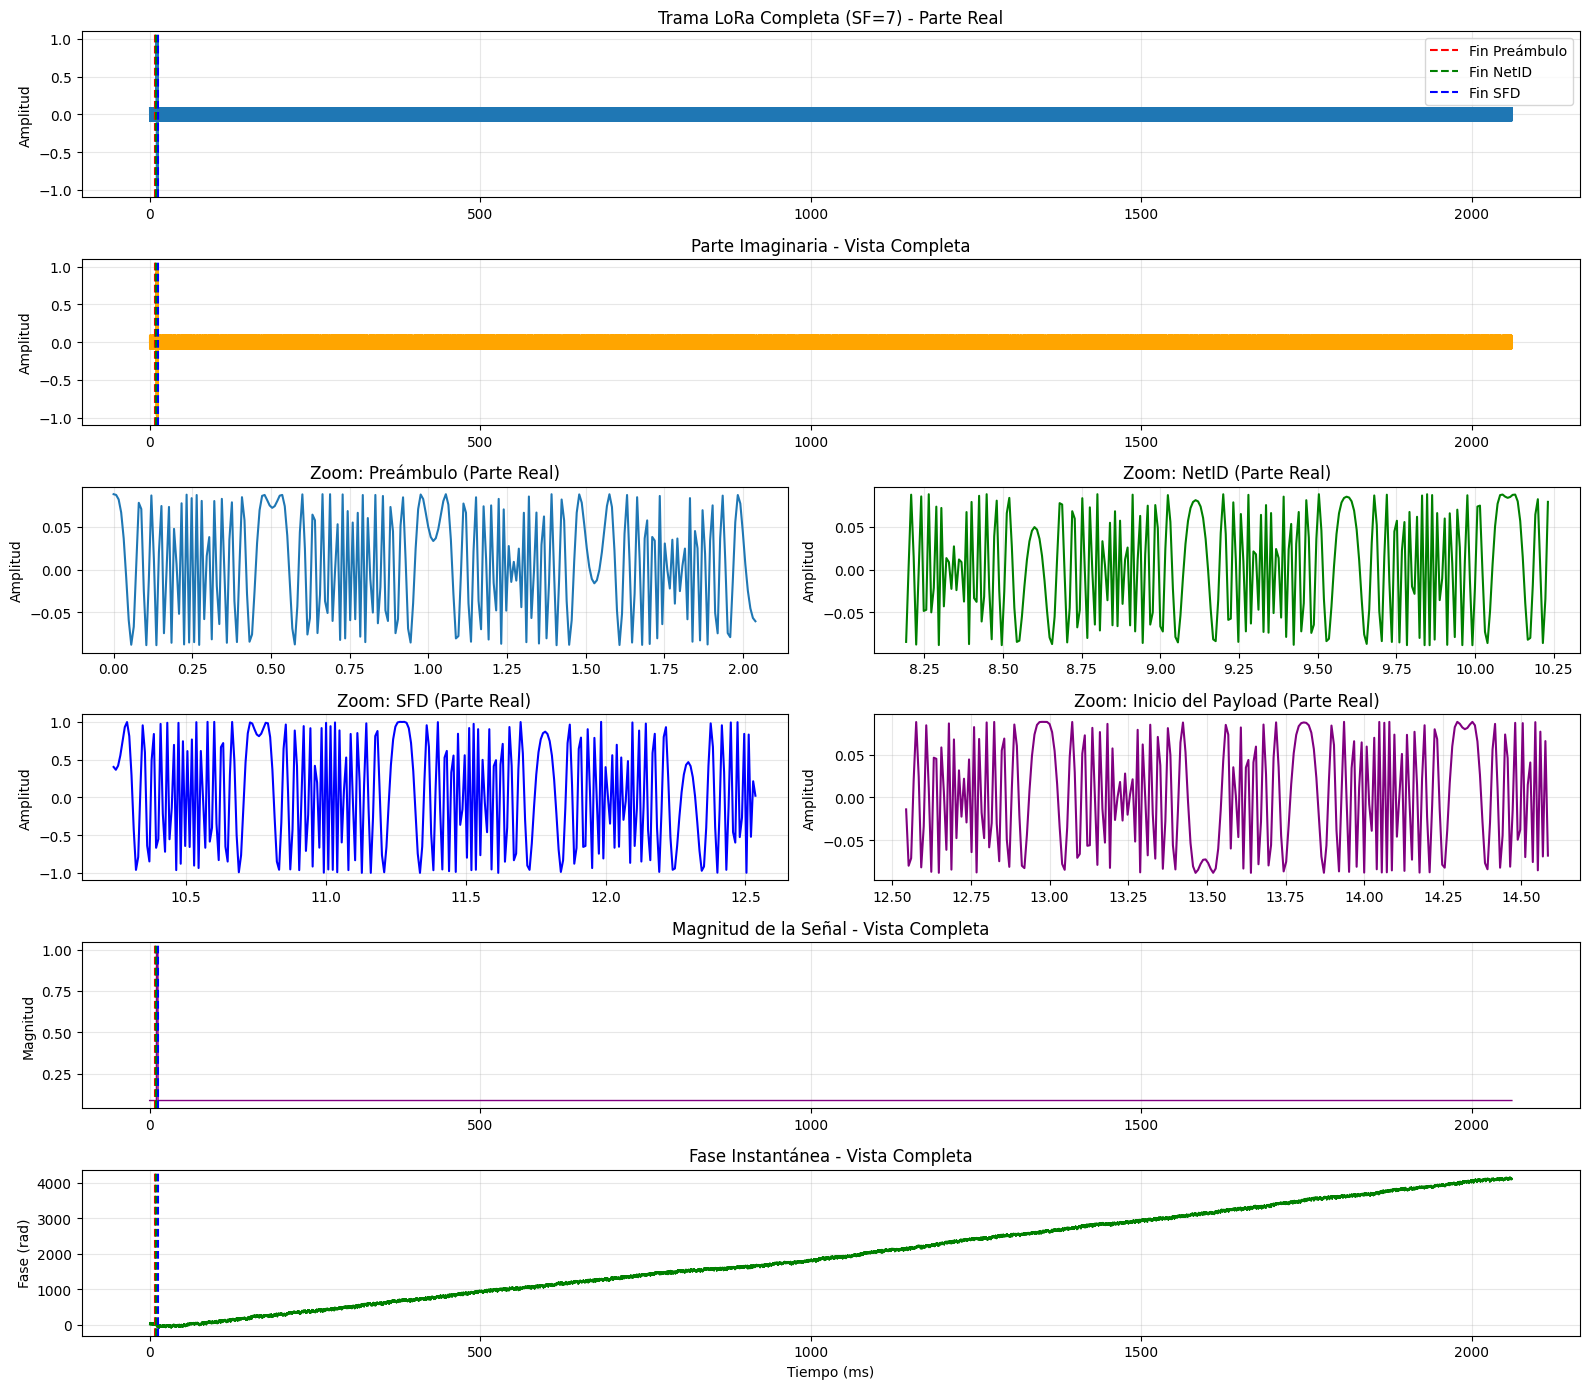

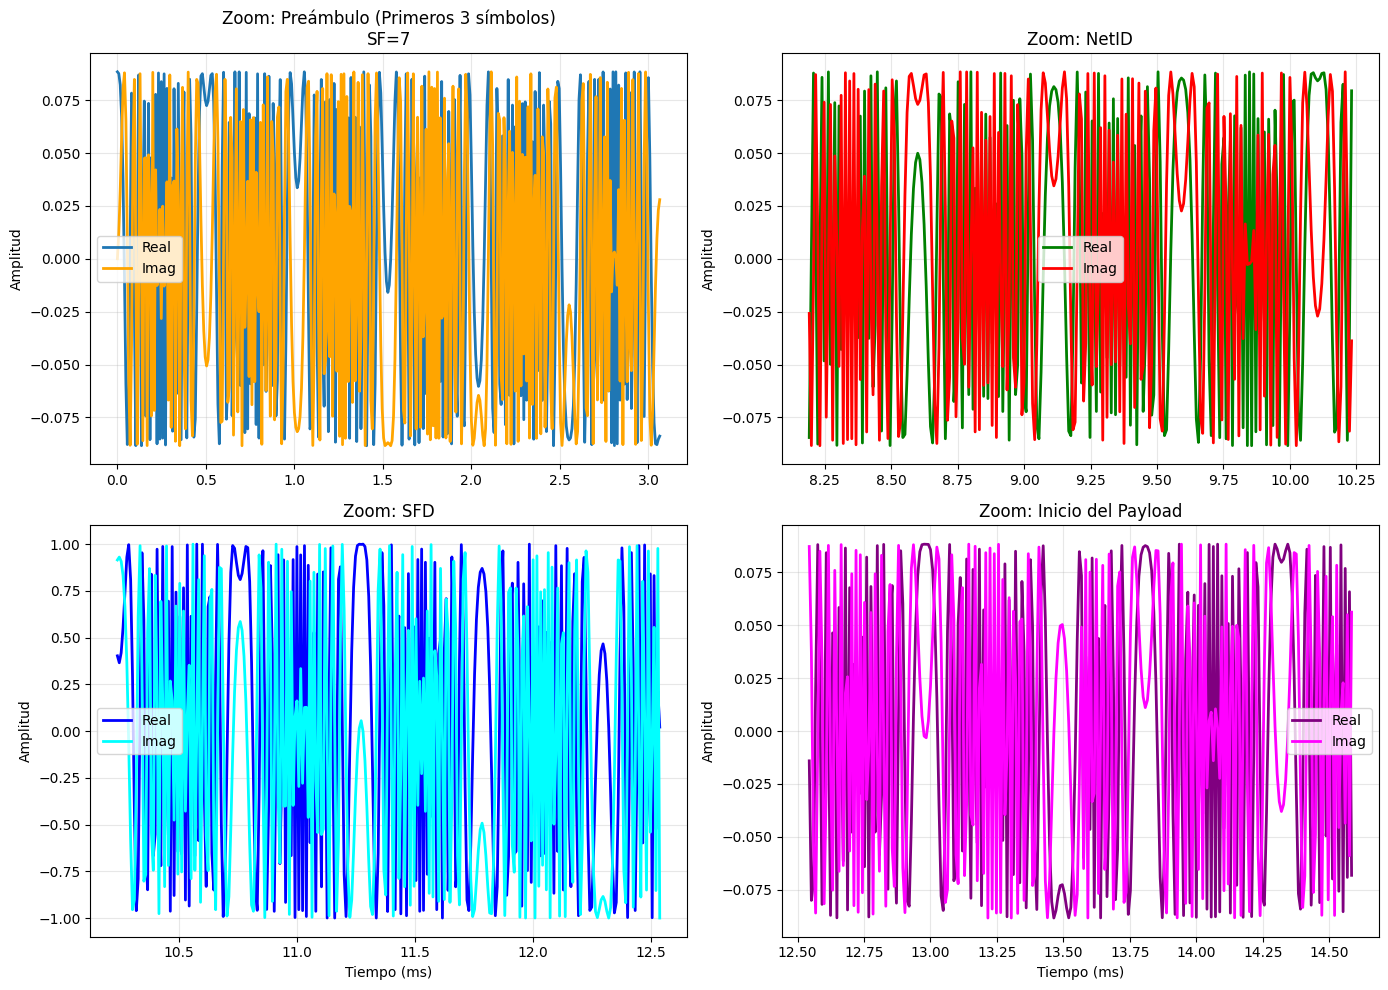

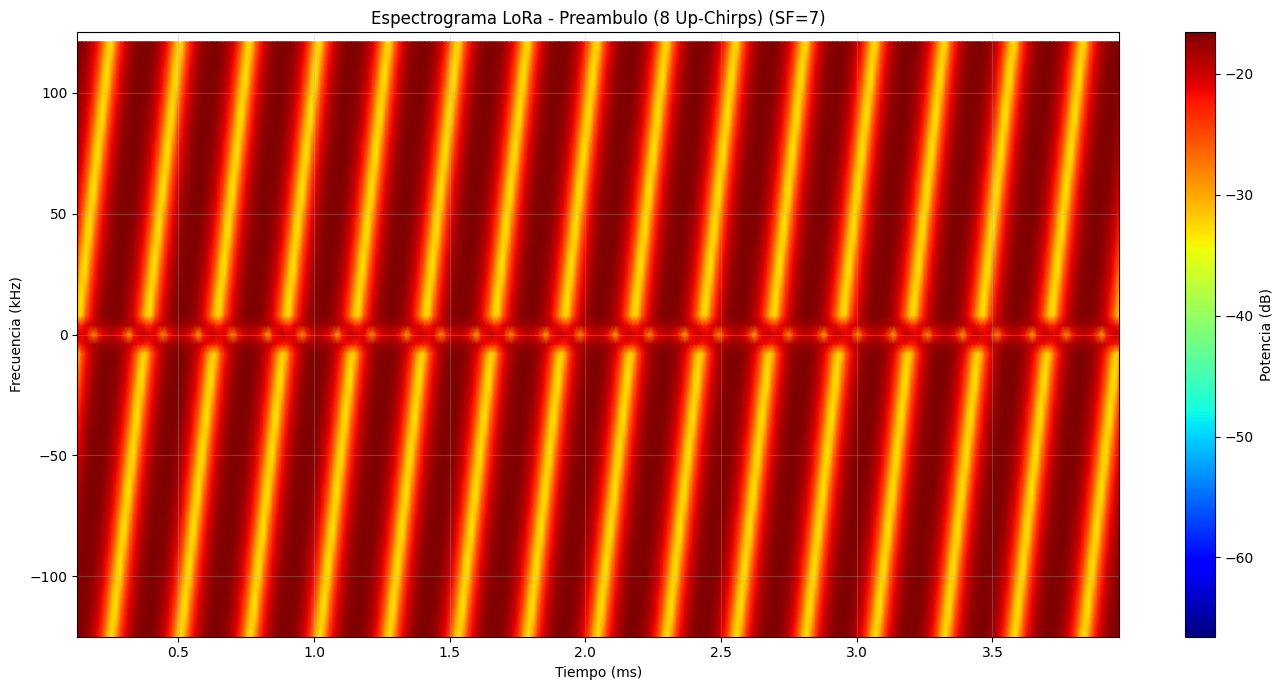

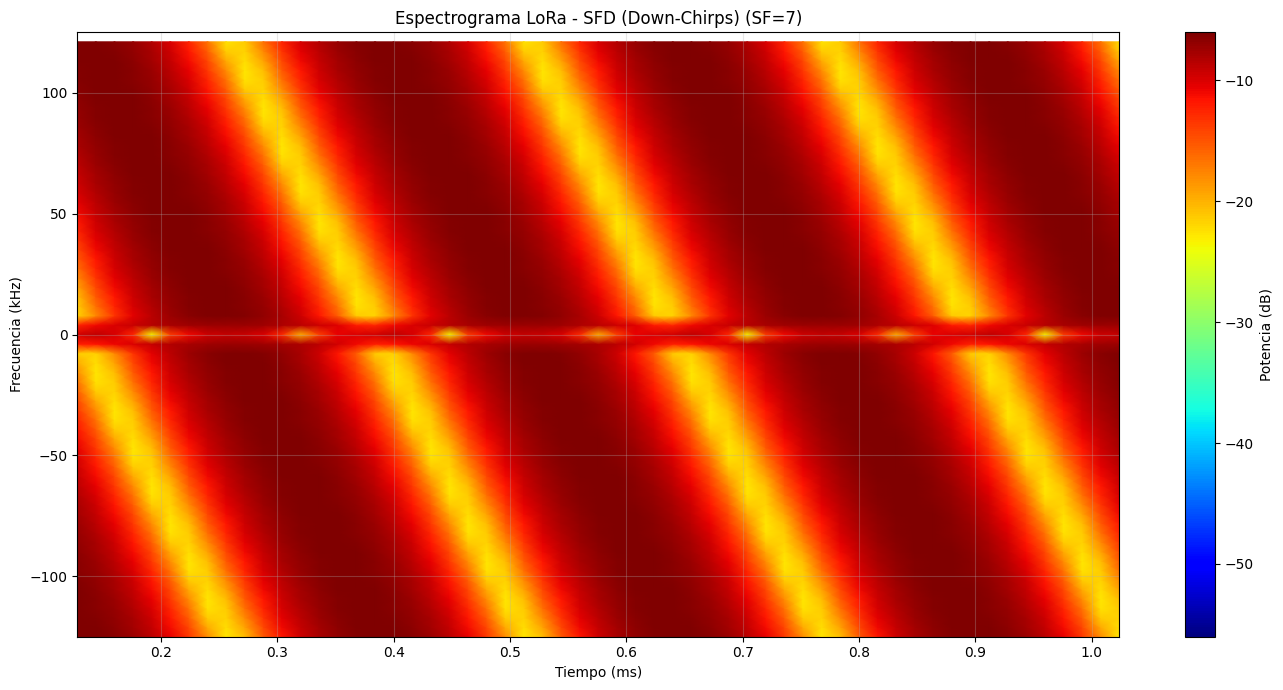

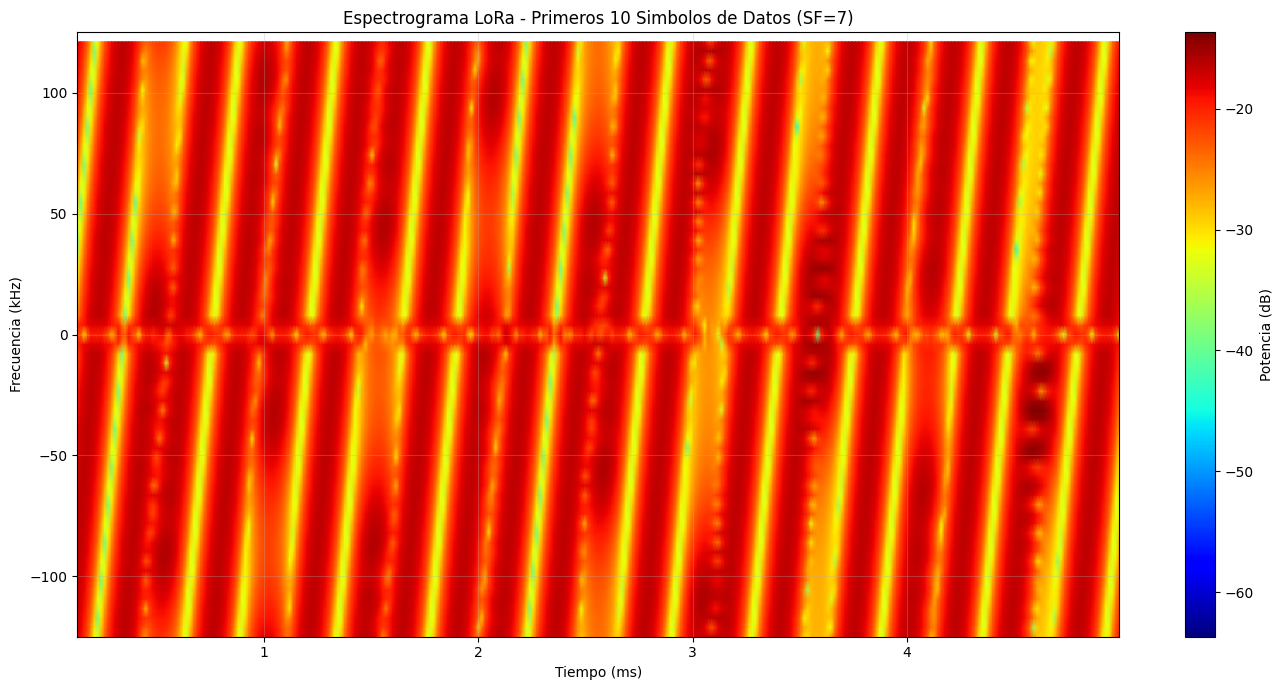

In [26]:
# ===========================================================================================
#                          GENERACIÓN DE GRÁFICAS DE LA TRAMA LORA
# ===========================================================================================

# 1. Gráfica completa de la trama
plot_lora_frame_zoom(tx_signal, M, SF, B)  
plot_lora_zoom_sections(tx_signal, M, SF, B)
# 2. Zoom en preámbulo
plot_spectrogram(tx_signal, B, SF, M, section='preamble')
# 3. Zoom en SFD
plot_spectrogram(tx_signal, B, SF, M, section='sfd')
# 4. Zoom en datos
plot_spectrogram(tx_signal, B, SF, M, section='data')

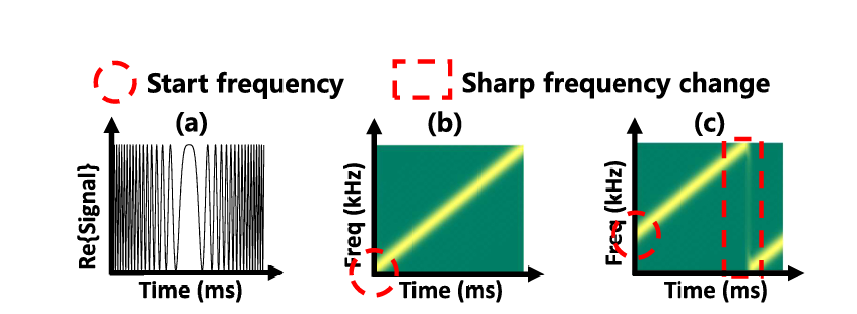

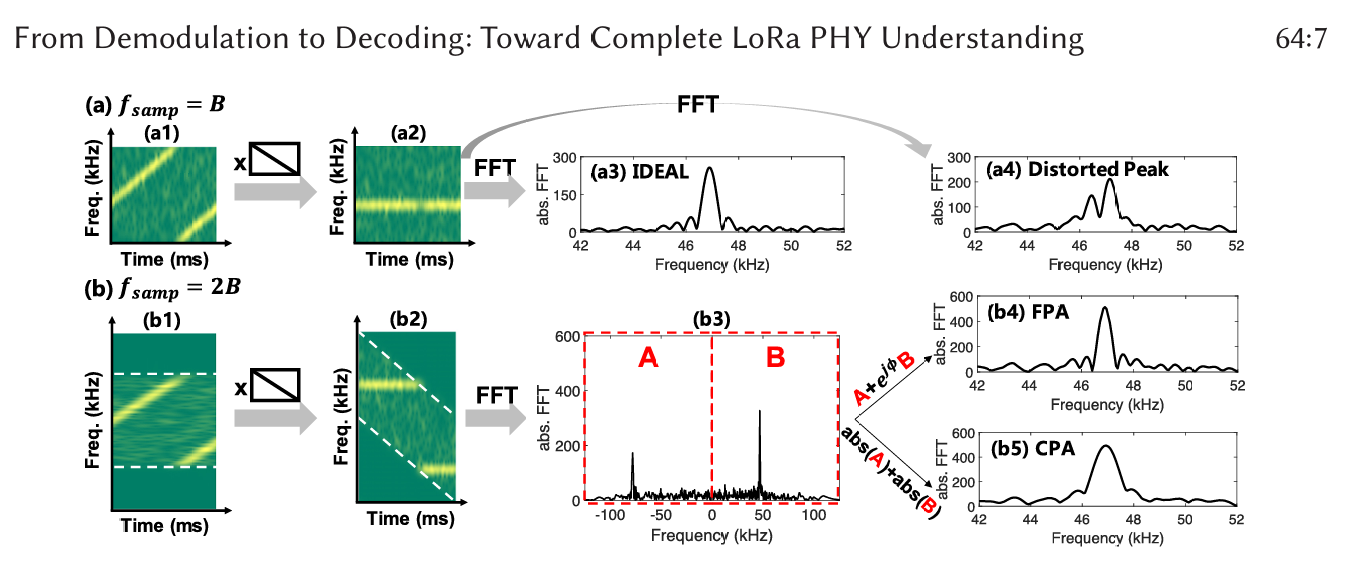

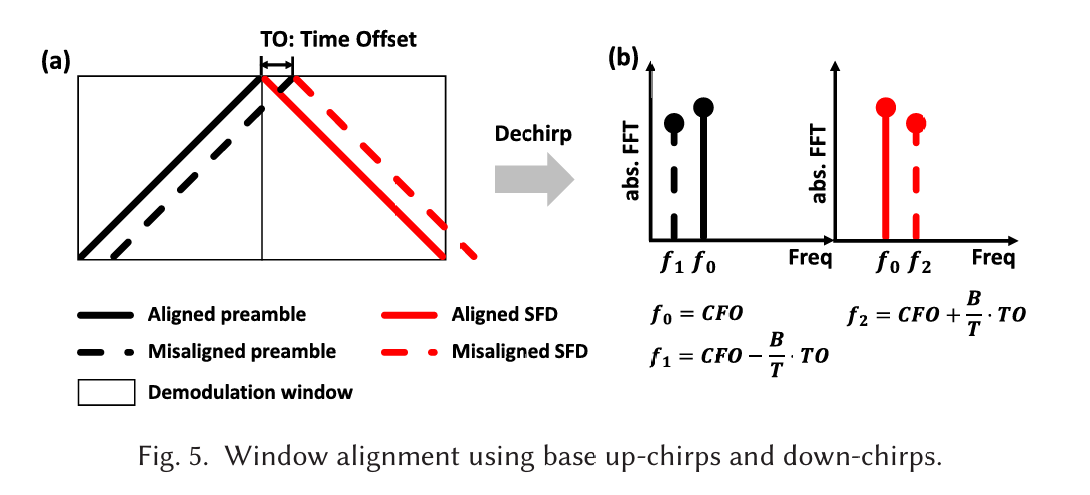

In [ ]:
###########################################################################
#                                                                         #
#  ██████  ███████  ██████ ███████ ██████   ██████ ██  ██████  ███    ██  #
#  ██   ██ ██      ██      ██      ██   ██ ██      ██ ██    ██ ████   ██  #
#  ██████  █████   ██      █████   ██████  ██      ██ ██    ██ ██ ██  ██  #
#  ██   ██ ██      ██      ██      ██      ██      ██ ██    ██ ██  ██ ██  #
#  ██   ██ ███████  ██████ ███████ ██       ██████ ██  ██████  ██   ████  #
#                                                                         #
###########################################################################

up_ref          = waveform_former(0, M, B, T)
down_ref        = make_down_ref(M, B, T)
zero_padding    = 10

#===========================================================================
#                                DETECCIÓN 
#===========================================================================
x = detect(tx_signal, 0, 2*M, 8, M, zero_padding, up_ref, mag_threshold=None)
if x != -1:
    preamble_start = x - (8 - 1) * M
    netid_len = 2 * M
    sfd_len = 2 * M + (M // 4)
    data_start_nom = preamble_start + 8 * M + netid_len + sfd_len
    print(f"Preambulo detectado = {x}")
    print(f"Inicio estimado del preámbulo = {preamble_start}")
    print(f"Inicio de datos = {data_start_nom}, símbolos de datos a procesar = {num_symbols}")
else:
    print("No se detectó preámbulo")

#===========================================================================
#                                SINCRONIZACIÓN
#===========================================================================
x_sync, preamble_bin, preamble_bin_zp, cfo_hz = sync(tx_signal, x, 2*M, M, zero_padding, up_ref, down_ref, B)
if x_sync == -1:
    print("Error en sincronización")
print(f"Sincronización exitosa: x_sync = {x_sync}, preamble_bin = {preamble_bin}, preamble_bin_zp = {preamble_bin_zp}, CFO = {cfo_hz} Hz")

cfo_bins_inj = cfo_hz_frame * M / B
cfo_bins_est_cont = (cfo_hz or 0.0) * M / B
print(f"CFO inj(cont)={cfo_bins_inj:.2f} bins | CFO est(cont)={cfo_bins_est_cont:.2f} bins | preamble_bin(entero)={(preamble_bin if preamble_bin<=M//2 else preamble_bin-M):.0f} bins")

def wrap_frac(x): return ((x + 0.5) % 1.0) - 0.5
pre_signed = preamble_bin if preamble_bin <= M//2 else preamble_bin - M
print(f"[CFO] entero(ref)={pre_signed:+.0f} | frac inj={wrap_frac(cfo_bins_inj-pre_signed):+.3f} | frac est={wrap_frac(cfo_bins_est_cont-pre_signed):+.3f}")

cfo_bins_est_zp = preamble_bin_zp / float(zero_padding)
print(f"[ZP] preamble_bin_zp={preamble_bin_zp} -> CFO_bins_est_ZP={cfo_bins_est_zp:.3f} (mod 1 bin)")

symbols_rx, num_avail = demod_data(tx_signal, x_sync, num_symbols, M, zero_padding, up_ref, preamble_bin_zp, cfo_hz, B)

# Métricas usando la cantidad procesada
tx_sym_chunk = symbols_tx[:num_avail]
rx_sym_chunk = symbols_rx[:num_avail]
num_symbol_errors = np.sum(tx_sym_chunk != rx_sym_chunk)
SER = num_symbol_errors / max(1, num_avail)

# Bits
nbits_proc = num_avail * SF
tx_bits_chunk = bits_tx[:nbits_proc]
rx_bits_chunk = decode_symbols_to_bits(rx_sym_chunk, SF)[:nbits_proc]
num_bit_errors = np.sum(tx_bits_chunk != rx_bits_chunk)
BER = num_bit_errors / max(1, nbits_proc)

print("\n================= RESULTADOS =================")
print(f"SF = {SF}, M = {M}")
print("Bits TX (primeros 20): ", bits_tx[:20])
print("Bits RX (primeros 20):", rx_bits_chunk[:20])
print("Símbolos TX (primeros 10):", symbols_tx[:10])
print("Símbolos RX (primeros 10):", symbols_rx[:10])
print(f"SER ideal: {SER}")
print(f"BER ideal: {BER}")

Preambulo detectado = 896
Inicio estimado del preámbulo = 0
Inicio de datos = 1568, símbolos de datos a procesar = 2000
Sincronización exitosa: x_sync = 1568, preamble_bin = 0, preamble_bin_zp = 1277, CFO = -248.44217378912072 Hz
CFO inj(cont)=-0.25 bins | CFO est(cont)=-0.25 bins | preamble_bin(entero)=0 bins
[CFO] entero(ref)=+0 | frac inj=-0.254 | frac est=-0.254
[ZP] preamble_bin_zp=1277 -> CFO_bins_est_ZP=127.700 (mod 1 bin)

================= RESULTADOS =================
SF = 7, M = 128
Bits TX (primeros 20):  [0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0]
Bits RX (primeros 20): [0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0]
Símbolos TX (primeros 10): [ 63  87  37  45 107  79  13  11 126  94]
Símbolos RX (primeros 10): [ 63  87  37  45 107  79  13  11 126  94]
SER ideal: 0.0
BER ideal: 0.0


# *SIMULACION CON RUIDO AWGN Y FRECUENCIA SELECTIVA + CFO*


===== Simulación SNR = -10 dB =====
Sincronización exitosa: x_sync = 2772, preamble_bin = 63, preamble_bin_zp = 626, CFO = 61140.16744597728 Hz
Sincronización exitosa: x_sync = 2448, preamble_bin = 115, preamble_bin_zp = 1145, CFO = -13180.004532383817 Hz
Sincronización exitosa: x_sync = 3156, preamble_bin = 60, preamble_bin_zp = 597, CFO = 58342.49798471099 Hz
Sincronización exitosa: x_sync = 2410, preamble_bin = 80, preamble_bin_zp = 799, CFO = -46948.74832732392 Hz
Sincronización exitosa: x_sync = 2766, preamble_bin = 53, preamble_bin_zp = 531, CFO = 51866.67256767975 Hz
Sincronización exitosa: x_sync = 2268, preamble_bin = 68, preamble_bin_zp = 680, CFO = -58584.64737579209 Hz
Sincronización exitosa: x_sync = 2508, preamble_bin = 51, preamble_bin_zp = 511, CFO = 49940.99980350427 Hz
Sincronización exitosa: x_sync = 2585, preamble_bin = 122, preamble_bin_zp = 1218, CFO = -6103.515625 Hz
Sincronización exitosa: x_sync = 2296, preamble_bin = 92, preamble_bin_zp = 922, CFO = -34975.97

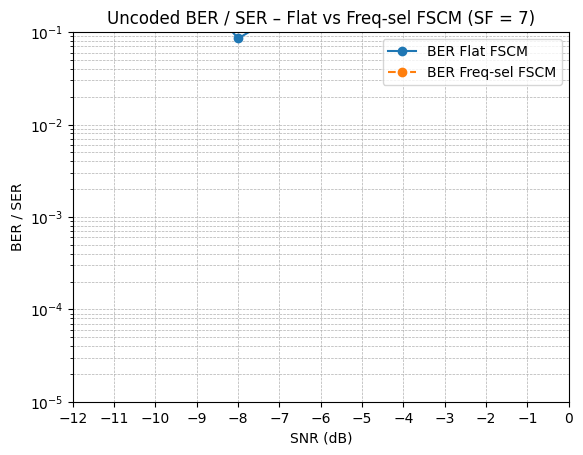

In [ ]:
def compute_sigma_from_signal(tx_signal, snr_dB):
    """Calcula sigma de ruido complejo a partir de potencia real de tx_signal y SNR (dB)."""
    signal_power = np.mean(np.abs(tx_signal)**2)
    SNR_linear = 10**(snr_dB / 10.0)
    sigma = np.sqrt(signal_power / (2.0 * SNR_linear))
    return sigma

# ===========================================================================================
#                          SIMULACIÓN DE CANAL CON RUIDO
# ===========================================================================================

snr_dB_range = np.arange(-10, -1, 1)                    # Es/N0 (dB)
EsN0_dB_range = snr_dB_range + 10*np.log10(M)           # Para simular se suma, ya que SNR dB = Es/N0 - 10log10(M)
Es = 1                                                  # Energía por símbolo (normalizada)
BER_awgn = np.zeros_like(snr_dB_range, dtype=float)
SER_awgn = np.zeros_like(snr_dB_range, dtype=float)

h_freqsel    = np.array([np.sqrt(0.8), np.sqrt(0.2)])   # √0.8 δ[n] + √0.2 δ[n-1]
BER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)
SER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)

Eb = Es / SF                                            # Energía por bit

up_ref              = waveform_former(0, M, B, T)
down_ref            = make_down_ref(M, B, T)

N_FRAMES = 10                   # cantidad de tramas por cada SNR
idle_base = 3 * M               # longitud del "idle" o ruido previo
jitter_max_samples = 10 * M     # máximo jitter en detección

for idx, snr_dB in enumerate(EsN0_dB_range):

    BER_tmp = np.zeros(N_FRAMES)
    SER_tmp = np.zeros(N_FRAMES)
    BER_tmp_sel = np.zeros(N_FRAMES)
    SER_tmp_sel = np.zeros(N_FRAMES)

    print(f"\n===== Simulación SNR = {snr_dB_range[idx]} dB =====")

    for frame_idx in range(N_FRAMES):

        # -----------------------------------------------------------------------------------
        #                          CANAL AWGN PLANO
        # -----------------------------------------------------------------------------------
        cfo_bins_frame = np.random.uniform(-1.0, 1.0)
        cfo_hz_frame = cfo_bins_frame * B / M

        # --- 1. Generar trama aleatoria
        bits_tx = np.random.randint(0, 2, size=num_bits)
        symbols_tx = encode_bits_to_symbols(bits_tx, SF)
        tx_frame = lora_modulate(symbols_tx, M, B, T)

        jitter = np.random.randint(0, jitter_max_samples + 1)
        idle_len_frame = idle_base + jitter
        noise_idle = (np.random.randn(idle_len_frame) + 1j*np.random.randn(idle_len_frame)) / np.sqrt(2)
        noise_idle *= np.sqrt(np.mean(np.abs(tx_frame)**2))
        noise_idle *= 0.1

         # --- 3. Concatenar idle + trama + CFO
        tx_signal_sin_cfo = np.concatenate([noise_idle, tx_frame])
        tx_signal = inject_cfo(tx_signal_sin_cfo, cfo_hz_frame, fs_eff=B)

        # --- 4. Aplicar canal y ruido AWGN
        sigma = compute_sigma_from_signal(tx_signal, snr_dB)
        noise = sigma * (np.random.randn(len(tx_signal)) + 1j*np.random.randn(len(tx_signal)))
        rx_signal = tx_signal + noise

        # --- 5. Detección de preámbulo
        x = detect(rx_signal, 0, M, 8, M, zero_padding, up_ref, mag_threshold=None)
        if x != -1:
            preamble_start = x - (8 - 1) * M
            netid_len = 2 * M
            sfd_len = 2 * M + (M // 4)
            data_start_nom = preamble_start + 8 * M + netid_len + sfd_len
            #print(f"Preambulo detectado = {x}")
            #print(f"Inicio estimado del preámbulo = {preamble_start}")
            #print(f"Inicio de datos = {data_start_nom}, símbolos de datos a procesar = {num_symbols}")
        else:
            print("No se detectó preámbulo - saltando SNR")
            continue

        # --- 6. Sincronización fina
        x_sync, preamble_bin, preamble_bin_zp, cfo_hz = sync(rx_signal, x, M, M, zero_padding, up_ref, down_ref, B)
        if x_sync == -1:
            print("Error en sincronización - saltando SNR")
            continue
        print(f"Sincronización exitosa: x_sync = {x_sync}, preamble_bin = {preamble_bin}, preamble_bin_zp = {preamble_bin_zp}, CFO = {cfo_hz} Hz")
             
        symbols_rx, num_avail = demod_data(tx_signal, x_sync, num_symbols, M, zero_padding, up_ref, preamble_bin_zp, cfo_hz, B)

        #--- 7. Cálculo de errores
        num_proc_symbols = num_avail
        if num_proc_symbols == 0:
            # no se demoduló nada: contar como fallo total
            SER_tmp[frame_idx] = 1.0
            BER_tmp[frame_idx] = 1.0
        else:
            # recortar el vector de símbolos transmitidos al número procesado
            tx_sym_chunk = symbols_tx[:num_proc_symbols]
            rx_sym_chunk = symbols_rx[:num_proc_symbols]

            # símbolo a símbolo
            num_symbol_errors = np.sum(tx_sym_chunk != rx_sym_chunk)
            SER_tmp[frame_idx] = num_symbol_errors / num_proc_symbols

            # ahora bits: recortar según símbolos realmente procesados
            nbits_proc = num_proc_symbols * SF
            tx_bits_chunk = bits_tx[:nbits_proc]
            rx_bits_chunk = decode_symbols_to_bits(rx_sym_chunk, SF)  # si ya tienes bits_rx, recorta directamente
            # asegúrate rx_bits_chunk tiene al menos nbits_proc (it should)
            rx_bits_chunk = rx_bits_chunk[:nbits_proc]

            num_bit_errors = np.sum(tx_bits_chunk != rx_bits_chunk)
            BER_tmp[frame_idx] = num_bit_errors / nbits_proc

     # --- 8. Promedio de resultados sobre las N tramas
    SER_awgn[idx] = np.mean(SER_tmp)
    BER_awgn[idx] = np.mean(BER_tmp)

    print(f"SER promedio (AWGN): {SER_awgn[idx]:.3e}, BER promedio (AWGN): {BER_awgn[idx]:.3e}")

    for frame_idx in range(N_FRAMES):

        # -----------------------------------------------------------------------------------
        #                          CANAL SELECTIVO EN FRECUENCIA
        # -----------------------------------------------------------------------------------

        cfo_bins_frame = np.random.uniform(-1.0, 1.0)
        cfo_hz_frame = cfo_bins_frame * B / M

        # --- 1. Generar trama aleatoria
        bits_tx = np.random.randint(0, 2, size=num_bits)
        symbols_tx = encode_bits_to_symbols(bits_tx, SF)
        tx_frame = lora_modulate(symbols_tx, M, B, T)

        jitter = np.random.randint(0, jitter_max_samples + 1)
        idle_len_frame = idle_base + jitter
        noise_idle = (np.random.randn(idle_len_frame) + 1j*np.random.randn(idle_len_frame)) / np.sqrt(2)
        noise_idle *= np.sqrt(np.mean(np.abs(tx_frame)**2))
        noise_idle *= 0.1

        # --- 3. Concatenar ruido previo + trama
        tx_signal = np.concatenate([noise_idle, tx_frame])

        tx_faded_sin_cfo = np.convolve(tx_signal, h_freqsel, mode='same')
        tx_faded = inject_cfo(tx_faded_sin_cfo, cfo_hz_frame, fs_eff=B)

        # --- 5. Añadir ruido AWGN
        sigma = compute_sigma_from_signal(tx_faded, snr_dB)
        noise_sel = sigma * (np.random.randn(len(tx_faded)) + 1j*np.random.randn(len(tx_faded)))
        rx_signal_sel = tx_faded + noise_sel

        # --- 6. Detección de preámbulo
        x = detect(rx_signal_sel, 0, M, 8, M, zero_padding, up_ref, mag_threshold=None)
        if x != -1:
            preamble_start = x - (8 - 1) * M
            netid_len = 2 * M
            sfd_len = 2 * M + (M // 4)
            data_start_nom = preamble_start + 8 * M + netid_len + sfd_len
            #print(f"Preambulo detectado = {x}")
            #print(f"Inicio estimado del preámbulo = {preamble_start}")
            #print(f"Inicio de datos = {data_start_nom}, símbolos de datos a procesar = {num_symbols}")
        else:
            print("No se detectó preámbulo - saltando SNR")
            continue

        # --- 6. Sincronización fina
        x_sync, preamble_bin, preamble_bin_zp, cfo_hz = sync(rx_signal_sel, x, M, M, zero_padding, up_ref, down_ref, B)
        if x_sync == -1:
            print("Error en sincronización - saltando SNR")
            continue
        print(f"Sincronización exitosa: x_sync = {x_sync}, preamble_bin = {preamble_bin}, preamble_bin_zp = {preamble_bin_zp}, CFO = {cfo_hz} Hz")

        symbols_rx, num_avail = demod_data(tx_signal, x_sync, num_symbols, M, zero_padding, up_ref, preamble_bin_zp, cfo_hz, B)

        #--- 7. Cálculo de errores
        num_proc_symbols = num_avail

        if num_proc_symbols == 0:
            # no se demoduló nada: contar como fallo total
            SER_tmp_sel[frame_idx] = 1.0
            BER_tmp_sel[frame_idx] = 1.0
        else:
            # recortar el vector de símbolos transmitidos al número procesado
            tx_sym_chunk = symbols_tx[:num_proc_symbols]
            rx_sym_chunk = symbols_rx[:num_proc_symbols]

            # símbolo a símbolo
            num_symbol_errors = np.sum(tx_sym_chunk != rx_sym_chunk)
            SER_tmp_sel[frame_idx] = num_symbol_errors / num_proc_symbols

            # ahora bits: recortar según símbolos realmente procesados
            nbits_proc = num_proc_symbols * SF
            tx_bits_chunk = bits_tx[:nbits_proc]
            rx_bits_chunk = decode_symbols_to_bits(rx_sym_chunk, SF)  # si ya tienes bits_rx, recorta directamente
            # asegúrate rx_bits_chunk tiene al menos nbits_proc (it should)
            rx_bits_chunk = rx_bits_chunk[:nbits_proc]

            num_bit_errors = np.sum(tx_bits_chunk != rx_bits_chunk)
            BER_tmp_sel[frame_idx] = num_bit_errors / nbits_proc

    # --- 9. Promedio sobre las N tramas
    SER_freqsel[idx] = np.mean(SER_tmp_sel)
    BER_freqsel[idx] = np.mean(BER_tmp_sel)

    print(f"SER promedio (Freq-sel): {SER_freqsel[idx]:.3e}, BER promedio (Freq-sel): {BER_freqsel[idx]:.3e}")
    
plt.figure()
plt.semilogy(snr_dB_range, BER_awgn,    'o-',  label='BER Flat FSCM')
#plt.semilogy(snr_dB_range, SER_awgn,    's-',  label='SER Flat FSCM')
plt.semilogy(snr_dB_range, BER_freqsel, 'o--', label='BER Freq-sel FSCM')
#plt.semilogy(snr_dB_range, SER_freqsel, 's--', label='SER Freq-sel FSCM')

plt.xlim(-12, 0)
plt.ylim(1e-5, 1e-1)
plt.xticks(np.arange(-12, 1, 1))
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('BER / SER')
plt.title('Uncoded BER / SER – Flat vs Freq-sel FSCM (SF = 7)')
plt.legend()
plt.show()